# URL Attention Exploration

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
from sklearn.model_selection import train_test_split
import numpy as np
from attn_utils import *
import matplotlib.pyplot as plt
from URL712 import plot_cm, make_ndir
from LSTMURL import RocAucEvaluation
%matplotlib inline

Using TensorFlow backend.
/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
read = 'last'
# read = 'front'

In [3]:
method = 'char'
# method = 'class'
units = 64
bi_units = 32
length = 10
n_epoch = 1

In [4]:
modeltype = 'LSTM'
# modeltype = 'GRU'

# training data
dataset, url_v, label_v, inv_label_v = load_dataset()

# test data
test_X, test_Y = load_testset()

In [5]:
print('URL vocab', url_v)

('URL vocab', {' ': 0, '$': 3, '(': 7, ',': 11, '0': 15, '4': 19, '8': 23, '<': 27, '@': 31, 'D': 35, 'H': 39, 'L': 43, 'P': 47, 'T': 51, 'X': 55, '\\': 59, '`': 63, 'd': 67, 'h': 71, 'l': 75, 'p': 79, 't': 83, 'x': 87, '|': 91, "'": 6, '+': 10, '/': 14, '3': 18, '7': 22, ';': 26, '?': 30, 'C': 34, 'G': 38, 'K': 42, 'O': 46, 'S': 50, 'W': 54, '[': 58, '_': 62, 'c': 66, 'g': 70, 'k': 74, 'o': 78, 's': 82, 'w': 86, '{': 90, '<unk>': 94, '"': 2, '&': 5, '*': 9, '.': 13, '2': 17, '6': 21, ':': 25, '>': 29, 'B': 33, 'F': 37, 'J': 41, 'N': 45, 'R': 49, 'V': 53, 'Z': 57, '^': 61, 'b': 65, 'f': 69, 'j': 73, 'n': 77, 'r': 81, 'v': 85, 'z': 89, '~': 93, '<pad>': 95, '!': 1, '%': 4, ')': 8, '-': 12, '1': 16, '5': 20, '9': 24, '=': 28, 'A': 32, 'E': 36, 'I': 40, 'M': 44, 'Q': 48, 'U': 52, 'Y': 56, ']': 60, 'a': 64, 'e': 68, 'i': 72, 'm': 76, 'q': 80, 'u': 84, 'y': 88, '}': 92})


In [6]:
print('URL vocab', label_v)

('URL vocab', {'+': 0, '-': 1})


In [7]:
print('URL vocab', inv_label_v)

('URL vocab', {0: '+', 1: '-'})


In [8]:
# Tx length of substring
Tx = length
Ty = 1
X, Y, Xoh, Yoh = preprocess_data(dataset, url_v, label_v, Tx, Ty,read, method)

[62, 23, 15, 24, 15, 13, 71, 83, 76, 75]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[16, 65, 64, 23, 23, 17, 15, 67, 65, 14]
[66, 14, 16, 68, 76, 81, 20, 21, 23, 14]
[4, 65, 18, 4, 65, 17, 4, 69, 64, 14]
[68, 12, 20, 17, 22, 13, 71, 83, 76, 75]
[30, 30, 4, 20, 66, 4, 20, 66, 84, 15]
[68, 75, 75, 68, 82, 13, 78, 81, 70, 14]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[23, 17, 19, 20, 22, 22, 24, 23, 16, 14]
[74, 64, 13, 73, 79, 70, 13, 89, 72, 79]
[23, 24, 21, 19, 18, 19, 21, 23, 16, 14]
[15, 22, 18, 23, 23, 20, 17, 16, 17, 14]
[20, 83, 88, 73, 21, 68, 71, 62, 85, 86]
[69, 78, 14, 69, 13, 71, 83, 76, 75, 30]
[24, 65, 65, 66, 17, 64, 23, 69, 69, 21]
[71, 78, 85, 68, 81, 13, 83, 78, 79, 14]
[76, 72, 77, 12, 82, 68, 81, 85, 68, 81]
[12, 68, 82, 82, 64, 88, 12, 17, 17, 19]
[69, 78, 14, 69, 13, 71, 83, 76, 75, 30]
[17, 4, 23, 18, 30, 30, 30, 30, 16, 4]
[64, 77, 72, 12, 81, 64, 67, 72, 78, 14]
[65, 67, 14, 70, 67, 78, 66, 66, 66, 14]
[81, 13, 71, 83, 76, 75, 30, 76, 28, 15]
[70, 15, 15, 19, 20, 17,

[83, 14, 71, 68, 75, 79, 13, 64, 82, 79]
[5, 81, 77, 67, 28, 16, 22, 15, 24, 17]
[22, 23, 17, 68, 21, 18, 21, 69, 21, 67]
[24, 18, 20, 23, 24, 67, 69, 67, 24, 66]
[72, 77, 69, 78, 14, 71, 70, 64, 83, 14]
[14, 75, 78, 70, 72, 77, 13, 71, 83, 76]
[72, 68, 86, 82, 14, 66, 79, 64, 77, 68]
[62, 20, 19, 19, 17, 18, 13, 68, 87, 68]
[22, 65, 66, 64, 22, 19, 65, 15, 18, 66]
[4, 20, 66, 4, 20, 66, 4, 17, 20, 20]
[65, 67, 84, 15, 15, 16, 64, 4, 17, 20]
[76, 88, 80, 15, 72, 64, 75, 72, 84, 15]
[16, 62, 20, 22, 15, 23, 13, 68, 87, 68]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[22, 21, 20, 20, 17, 68, 22, 65, 67, 65]
[89, 71, 78, 77, 70, 66, 13, 79, 86, 14]
[18, 12, 23, 24, 21, 15, 13, 68, 87, 68]
[25, 14, 5, 75, 68, 85, 68, 75, 28, 15]
[30, 30, 64, 30, 30, 30, 4, 17, 20, 18]
[64, 83, 72, 78, 77, 14, 70, 83, 68, 87]
[82, 79, 75, 64, 88, 13, 71, 83, 76, 75]
[66, 12, 65, 64, 77, 74, 13, 79, 71, 79]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[22, 18, 19, 22, 24, 18, 24, 23, 67, 68]
[75, 84, 67, 68, 82, 14,

[17, 64, 21, 17, 69, 64, 67, 67, 22, 15]
[69, 4, 18, 69, 4, 18, 69, 4, 18, 69]
[14, 70, 81, 72, 67, 13, 71, 83, 76, 75]
[81, 72, 68, 82, 14, 69, 72, 75, 68, 14]
[14, 75, 78, 70, 72, 77, 13, 79, 71, 79]
[14, 88, 64, 71, 78, 78, 13, 79, 71, 79]
[22, 15, 21, 69, 21, 22, 15, 24, 20, 19]
[59, 59, 59, 59, 59, 59, 59, 59, 4, 20]
[22, 24, 20, 20, 65, 66, 16, 64, 24, 64]
[68, 81, 14, 79, 64, 70, 68, 14, 17, 14]
[69, 4, 18, 69, 4, 18, 69, 4, 17, 20]
[59, 59, 59, 59, 59, 59, 59, 84, 15, 15]
[84, 69, 69, 69, 67, 84, 69, 69, 69, 67]
[82, 12, 66, 71, 64, 84, 67, 68, 82, 14]
[69, 4, 18, 69, 4, 18, 69, 4, 18, 69]
[69, 4, 68, 69, 4, 65, 69, 4, 65, 67]
[4, 66, 18, 4, 23, 18, 30, 30, 4, 17]
[19, 17, 15, 15, 14, 19, 23, 15, 21, 22]
[77, 69, 78, 14, 69, 13, 71, 83, 76, 75]
[30, 30, 30, 30, 30, 30, 30, 30, 4, 17]
[30, 30, 4, 17, 66, 17, 64, 30, 30, 4]
[16, 23, 67, 15, 66, 64, 24, 23, 15, 24]
[20, 67, 20, 19, 20, 19, 20, 68, 20, 20]
[66, 67, 64, 16, 65, 24, 24, 18, 65, 67]
[72, 67, 78, 86, 77, 13, 66, 78, 76

[22, 22, 21, 20, 15, 13, 71, 83, 76, 75]
[79, 12, 85, 68, 15, 13, 70, 67, 77, 14]
[22, 15, 24, 20, 5, 85, 28, 17, 13, 15]
[74, 65, 78, 64, 81, 67, 13, 71, 83, 76]
[19, 17, 20, 21, 19, 16, 23, 5, 69, 72]
[20, 66, 84, 15, 15, 16, 64, 4, 17, 20]
[67, 4, 18, 69, 4, 18, 69, 64, 4, 18]
[20, 22, 16, 62, 17, 13, 71, 83, 76, 75]
[14, 72, 77, 67, 68, 87, 13, 71, 83, 76]
[78, 79, 77, 68, 86, 17, 15, 16, 21, 14]
[20, 24, 21, 67, 24, 18, 65, 23, 18, 20]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 18]
[80, 67, 76, 86, 72, 89, 88, 86, 67, 78]
[83, 14, 71, 84, 78, 18, 69, 18, 89, 24]
[21, 15, 69, 69, 16, 68, 65, 18, 16, 19]
[23, 19, 18, 16, 69, 17, 5, 85, 28, 18]
[14, 16, 16, 14, 82, 68, 66, 84, 81, 68]
[17, 20, 15, 17, 23, 84, 15, 15, 17, 21]
[69, 20, 66, 21, 17, 18, 24, 21, 21, 64]
[14, 86, 72, 77, 69, 78, 13, 79, 71, 79]
[21, 79, 81, 78, 67, 84, 66, 83, 62, 69]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[17, 4, 65, 67, 4, 66, 18, 4, 64, 69]
[22, 87, 83, 82, 16, 18, 89, 75, 73, 78]
[16, 24, 23, 16, 18, 16, 1

[82, 72, 67, 68, 77, 83, 72, 64, 75, 14]
[77, 67, 68, 87, 16, 13, 71, 83, 76, 75]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[77, 64, 81, 66, 71, 88, 13, 69, 81, 14]
[68, 77, 83, 78, 83, 13, 71, 83, 76, 75]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[83, 84, 64, 81, 88, 13, 66, 78, 76, 14]
[14, 71, 78, 76, 68, 13, 71, 83, 76, 75]
[75, 78, 70, 77, 64, 13, 66, 78, 76, 14]
[75, 68, 83, 83, 68, 13, 66, 78, 76, 14]
[68, 20, 69, 64, 64, 15, 21, 16, 23, 24]
[16, 13, 71, 84, 65, 13, 65, 72, 89, 14]
[83, 78, 12, 66, 84, 13, 71, 83, 76, 75]
[13, 66, 78, 76, 14, 71, 78, 76, 68, 14]
[68, 82, 13, 66, 78, 76, 13, 84, 64, 14]
[83, 88, 82, 82, 81, 13, 66, 78, 76, 14]
[81, 85, 68, 13, 66, 78, 13, 74, 81, 14]
[71, 66, 18, 21, 15, 13, 66, 78, 76, 14]
[75, 75, 12, 79, 68, 78, 79, 75, 68, 14]
[72, 77, 70, 62, 72, 76, 64, 70, 68, 82]
[12, 67, 81, 78, 65, 72, 75, 74, 72, 14]
[15, 20, 21, 21, 64, 67, 21, 68, 18, 21]
[83, 12, 66, 78, 87, 12, 76, 12, 67, 14]
[67, 68, 79, 78, 83, 13, 66, 78, 76, 14]
[76, 68, 67, 72,

[68, 68, 67, 78, 76, 13, 66, 78, 76, 14]
[22, 24, 13, 16, 22, 13, 17, 15, 23, 14]
[68, 81, 72, 77, 70, 13, 64, 82, 79, 87]
[77, 70, 81, 78, 78, 76, 13, 72, 77, 66]
[67, 86, 68, 65, 14, 79, 64, 70, 68, 82]
[21, 16, 21, 16, 15, 17, 16, 22, 18, 19]
[84, 83, 78, 12, 75, 72, 69, 83, 82, 14]
[67, 78, 81, 68, 82, 13, 71, 83, 76, 75]
[74, 81, 64, 74, 78, 86, 13, 79, 75, 14]
[14, 72, 77, 67, 68, 87, 13, 71, 83, 76]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[72, 83, 72, 13, 66, 78, 13, 72, 77, 14]
[72, 65, 75, 68, 82, 13, 71, 83, 76, 75]
[84, 83, 82, 66, 71, 13, 66, 78, 76, 14]
[68, 66, 78, 77, 67, 13, 71, 83, 76, 75]
[66, 64, 75, 79, 12, 79, 64, 72, 77, 14]
[18, 23, 20, 65, 68, 11, 12, 18, 13, 15]
[83, 72, 78, 77, 12, 76, 64, 81, 66, 71]
[82, 74, 64, 83, 68, 13, 71, 83, 76, 75]
[72, 65, 81, 78, 82, 13, 71, 83, 76, 75]
[77, 83, 81, 78, 75, 13, 66, 78, 76, 14]
[64, 13, 68, 82, 14, 72, 66, 64, 81, 78]
[80, 72, 64, 77, 24, 23, 19, 24, 18, 14]
[22, 18, 13, 17, 22, 13, 17, 20, 15, 14]
[16, 13, 17, 16,

[81, 28, 16, 5, 78, 82, 72, 67, 28, 16]
[65, 67, 81, 76, 82, 13, 66, 78, 76, 14]
[22, 22, 16, 15, 15, 17, 20, 15, 18, 15]
[72, 82, 83, 81, 88, 13, 66, 78, 76, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[21, 17, 13, 17, 19, 19, 13, 20, 21, 14]
[88, 77, 68, 74, 13, 72, 77, 69, 78, 14]
[75, 68, 72, 70, 71, 13, 66, 78, 76, 14]
[79, 71, 78, 83, 78, 13, 66, 78, 76, 14]
[13, 81, 78, 14, 83, 81, 64, 66, 74, 82]
[14, 74, 78, 77, 83, 64, 74, 83, 88, 14]
[68, 76, 72, 77, 64, 81, 14, 20, 21, 20]
[24, 19, 18, 16, 24, 24, 16, 21, 18, 23]
[18, 22, 13, 21, 21, 13, 17, 16, 24, 14]
[64, 82, 83, 84, 74, 13, 66, 78, 76, 14]
[21, 12, 76, 64, 72, 77, 13, 79, 67, 69]
[77, 12, 67, 68, 77, 13, 66, 78, 76, 14]
[68, 77, 13, 66, 78, 76, 13, 76, 87, 14]
[65, 30, 67, 78, 86, 77, 75, 78, 64, 67]
[82, 64, 75, 68, 82, 13, 77, 68, 83, 14]
[82, 82, 78, 75, 72, 13, 66, 78, 76, 14]
[78, 84, 77, 70, 68, 13, 66, 78, 76, 14]
[23, 23, 18, 17, 21, 18, 21, 22, 15, 22]
[12, 71, 68, 75, 79, 12, 79, 64, 70, 68]
[68, 75, 12, 67, 

[78, 79, 72, 68, 67, 64, 67, 68, 82, 14]
[64, 82, 83, 81, 64, 13, 66, 78, 76, 14]
[85, 87, 64, 77, 84, 13, 66, 78, 76, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[84, 77, 70, 66, 22, 18, 68, 21, 65, 15]
[78, 75, 71, 84, 65, 13, 66, 78, 76, 14]
[82, 72, 83, 68, 82, 13, 66, 78, 76, 14]
[81, 81, 68, 83, 83, 13, 66, 78, 76, 14]
[24, 22, 67, 23, 69, 13, 66, 78, 76, 14]
[21, 83, 88, 78, 64, 75, 87, 70, 86, 28]
[64, 83, 72, 78, 77, 13, 78, 81, 70, 14]
[13, 19, 23, 13, 23, 19, 13, 18, 16, 14]
[75, 87, 88, 88, 81, 13, 66, 78, 76, 14]
[77, 72, 87, 72, 67, 13, 66, 78, 76, 14]
[84, 81, 72, 83, 88, 13, 66, 78, 76, 14]
[76, 81, 22, 24, 64, 5, 79, 85, 28, 17]
[30, 30, 30, 20, 30, 30, 20, 30, 4, 18]
[66, 71, 66, 65, 66, 13, 66, 78, 76, 14]
[76, 79, 81, 68, 82, 82, 68, 67, 28, 15]
[28, 79, 81, 78, 67, 84, 66, 83, 78, 82]
[12, 82, 83, 64, 81, 83, 13, 67, 68, 14]
[81, 12, 77, 68, 83, 13, 66, 78, 76, 14]
[65, 84, 81, 74, 68, 13, 66, 78, 76, 14]
[22, 14, 85, 68, 81, 83, 72, 70, 78, 14]
[84, 83, 68, 81, 8

[86, 68, 65, 68, 81, 13, 66, 78, 76, 14]
[16, 23, 19, 15, 19, 24, 20, 19, 16, 21]
[5, 78, 79, 68, 81, 64, 83, 78, 81, 28]
[68, 86, 64, 82, 64, 13, 66, 78, 76, 14]
[65, 75, 78, 70, 68, 82, 13, 72, 81, 14]
[66, 65, 81, 64, 82, 82, 13, 82, 68, 14]
[73, 85, 20, 70, 76, 22, 85, 70, 14, 30]
[17, 16, 16, 17, 19, 16, 24, 24, 17, 21]
[64, 79, 72, 77, 70, 13, 66, 78, 76, 14]
[77, 78, 84, 77, 66, 68, 76, 68, 77, 83]
[64, 12, 84, 13, 64, 66, 13, 73, 79, 14]
[67, 64, 67, 68, 82, 13, 77, 68, 83, 14]
[84, 76, 68, 71, 80, 13, 66, 78, 76, 14]
[12, 79, 81, 68, 70, 77, 64, 77, 83, 14]
[15, 17, 21, 24, 19, 21, 21, 16, 19, 21]
[79, 14, 19, 22, 22, 21, 17, 20, 16, 14]
[69, 64, 67, 84, 75, 13, 66, 78, 76, 14]
[24, 24, 69, 67, 69, 17, 66, 17, 24, 16]
[83, 75, 68, 81, 64, 70, 13, 66, 71, 14]
[72, 82, 83, 81, 88, 13, 66, 78, 76, 14]
[14, 64, 65, 78, 84, 83, 12, 84, 82, 14]
[81, 72, 14, 17, 24, 17, 17, 17, 18, 15]
[78, 81, 72, 77, 70, 13, 66, 78, 76, 14]
[83, 12, 66, 84, 81, 81, 88, 12, 76, 67]
[77, 89, 13, 66, 

[24, 24, 69, 67, 69, 17, 66, 17, 24, 18]
[79, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[76, 78, 77, 68, 88, 13, 66, 78, 76, 14]
[16, 22, 67, 15, 23, 15, 15, 24, 69, 14]
[64, 82, 79, 30, 72, 67, 28, 24, 22, 23]
[14, 74, 84, 70, 78, 13, 71, 83, 76, 75]
[71, 72, 76, 69, 68, 87, 13, 84, 82, 14]
[79, 64, 77, 69, 75, 84, 13, 79, 67, 69]
[64, 74, 68, 81, 82, 13, 64, 82, 79, 87]
[64, 82, 72, 83, 68, 13, 66, 78, 76, 14]
[78, 81, 83, 68, 81, 13, 77, 68, 83, 14]
[78, 81, 77, 68, 88, 13, 66, 78, 76, 14]
[81, 64, 13, 66, 78, 76, 13, 64, 81, 14]
[81, 68, 67, 72, 81, 28, 83, 81, 84, 68]
[82, 83, 65, 78, 87, 13, 66, 78, 76, 14]
[78, 70, 82, 79, 78, 83, 13, 83, 86, 14]
[77, 66, 68, 12, 83, 85, 13, 73, 79, 14]
[64, 75, 64, 77, 72, 13, 66, 78, 76, 14]
[64, 74, 68, 81, 88, 13, 66, 78, 76, 14]
[78, 76, 72, 66, 82, 13, 66, 78, 76, 14]
[68, 82, 82, 68, 67, 13, 66, 78, 76, 14]
[68, 89, 78, 81, 70, 13, 77, 68, 83, 14]
[18, 13, 16, 19, 24, 13, 16, 19, 24, 14]
[71, 78, 79, 79, 82, 13, 83, 78, 79, 14]
[73, 68, 83, 89,

[68, 75, 64, 77, 67, 13, 66, 78, 76, 14]
[82, 17, 17, 18, 16, 13, 71, 83, 76, 75]
[68, 66, 83, 78, 81, 13, 66, 78, 76, 14]
[71, 68, 22, 13, 66, 78, 13, 84, 74, 14]
[20, 16, 15, 19, 22, 17, 21, 15, 22, 19]
[84, 81, 77, 64, 75, 13, 66, 78, 76, 14]
[68, 65, 68, 66, 66, 64, 12, 18, 18, 16]
[88, 82, 75, 83, 67, 13, 66, 78, 76, 14]
[76, 82, 17, 15, 16, 22, 13, 79, 67, 69]
[78, 81, 72, 77, 70, 13, 66, 78, 76, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[74, 68, 81, 72, 67, 28, 16, 15, 23, 19]
[12, 75, 84, 74, 64, 82, 13, 68, 84, 14]
[81, 78, 14, 72, 67, 14, 20, 18, 15, 15]
[83, 12, 83, 78, 12, 81, 72, 70, 71, 83]
[83, 64, 77, 83, 82, 13, 66, 78, 76, 14]
[68, 75, 83, 78, 77, 13, 66, 78, 76, 14]
[81, 70, 78, 70, 77, 68, 13, 69, 81, 14]
[78, 81, 69, 68, 88, 13, 78, 81, 70, 14]
[86, 86, 13, 64, 85, 86, 13, 67, 68, 14]
[17, 65, 16, 21, 23, 13, 66, 78, 76, 14]
[67, 84, 75, 67, 84, 24, 79, 86, 28, 28]
[84, 81, 68, 12, 71, 78, 84, 82, 68, 14]
[83, 78, 81, 68, 82, 13, 66, 78, 76, 14]
[78, 83, 68, 75,

[17, 80, 13, 84, 89, 22, 71, 86, 80, 28]
[64, 83, 72, 78, 77, 13, 66, 78, 76, 14]
[5, 82, 20, 28, 5, 77, 68, 86, 28, 16]
[13, 78, 81, 70, 14, 65, 72, 78, 82, 14]
[23, 12, 76, 64, 72, 77, 13, 79, 67, 69]
[72, 82, 83, 68, 81, 13, 66, 78, 76, 14]
[72, 85, 64, 81, 72, 13, 71, 83, 76, 75]
[18, 24, 13, 16, 20, 15, 13, 22, 23, 14]
[66, 83, 64, 70, 64, 16, 69, 72, 20, 84]
[68, 87, 72, 84, 76, 13, 66, 78, 76, 14]
[68, 82, 72, 78, 77, 64, 81, 72, 78, 82]
[68, 65, 64, 64, 81, 67, 13, 77, 75, 14]
[16, 23, 13, 21, 21, 13, 16, 22, 20, 14]
[72, 72, 72, 72, 72, 72, 13, 76, 75, 14]
[78, 76, 78, 72, 67, 28, 16, 17, 24, 17]
[68, 82, 83, 23, 16, 17, 13, 81, 84, 14]
[14, 17, 20, 15, 74, 65, 13, 67, 68, 14]
[82, 68, 81, 85, 68, 81, 13, 67, 68, 14]
[78, 76, 62, 66, 78, 77, 83, 68, 77, 83]
[67, 68, 12, 76, 64, 67, 68, 81, 64, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[66, 83, 17, 15, 16, 18, 13, 79, 67, 69]
[64, 88, 13, 66, 78, 76, 13, 64, 84, 14]
[76, 64, 70, 72, 66, 13, 66, 78, 76, 14]
[81, 77, 64, 75, 1

[78, 83, 68, 66, 71, 13, 66, 78, 76, 14]
[76, 78, 78, 86, 13, 69, 64, 81, 76, 14]
[68, 77, 76, 68, 77, 13, 66, 78, 76, 14]
[75, 72, 77, 69, 78, 13, 71, 83, 76, 75]
[71, 22, 81, 84, 15, 81, 84, 81, 71, 19]
[72, 77, 67, 72, 64, 13, 66, 78, 76, 14]
[66, 64, 81, 72, 17, 13, 71, 83, 76, 75]
[70, 81, 78, 84, 79, 13, 77, 68, 83, 14]
[72, 77, 67, 68, 87, 13, 64, 82, 79, 87]
[74, 71, 64, 75, 72, 77, 13, 81, 84, 14]
[81, 72, 82, 76, 68, 13, 77, 68, 83, 14]
[76, 79, 82, 13, 66, 78, 13, 84, 74, 14]
[70, 83, 78, 76, 68, 13, 77, 68, 83, 14]
[12, 68, 77, 12, 19, 17, 16, 15, 23, 14]
[78, 81, 76, 68, 81, 13, 66, 78, 76, 14]
[17, 15, 20, 13, 23, 21, 13, 21, 20, 14]
[67, 84, 66, 83, 82, 13, 85, 72, 68, 86]
[68, 76, 68, 15, 15, 13, 66, 78, 76, 14]
[84, 82, 72, 66, 64, 13, 66, 78, 76, 14]
[64, 84, 12, 89, 12, 86, 64, 85, 68, 14]
[81, 67, 78, 84, 70, 71, 13, 66, 78, 14]
[68, 88, 75, 78, 77, 13, 66, 78, 76, 14]
[68, 81, 82, 64, 75, 13, 66, 78, 76, 14]
[16, 13, 16, 17, 22, 13, 16, 17, 18, 14]
[65, 72, 75, 68,

[64, 72, 75, 68, 88, 13, 66, 78, 76, 14]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[14, 14, 66, 85, 16, 21, 13, 73, 79, 14]
[82, 82, 64, 77, 78, 83, 13, 72, 83, 14]
[77, 69, 64, 77, 68, 13, 66, 78, 76, 14]
[64, 82, 24, 16, 16, 13, 66, 78, 76, 14]
[84, 75, 75, 64, 12, 82, 64, 81, 72, 14]
[79, 75, 13, 68, 67, 84, 13, 66, 77, 14]
[66, 83, 78, 81, 72, 64, 13, 68, 82, 14]
[22, 17, 17, 17, 23, 17, 20, 21, 16, 19]
[21, 19, 5, 82, 75, 72, 67, 68, 28, 16]
[67, 68, 87, 12, 68, 77, 13, 71, 83, 76]
[68, 13, 71, 84, 65, 13, 65, 72, 89, 14]
[82, 72, 83, 68, 67, 13, 66, 78, 76, 14]
[14, 88, 64, 75, 78, 76, 13, 79, 79, 83]
[72, 75, 83, 68, 81, 13, 71, 83, 76, 75]
[81, 82, 78, 69, 64, 13, 66, 78, 76, 14]
[84, 77, 83, 82, 13, 66, 75, 84, 65, 14]
[71, 78, 83, 78, 82, 13, 66, 78, 76, 14]
[71, 85, 13, 78, 81, 70, 13, 82, 70, 14]
[64, 65, 75, 68, 13, 71, 83, 76, 75, 14]
[78, 79, 72, 69, 88, 13, 66, 78, 76, 14]
[23, 64, 69, 76, 80, 21, 67, 78, 64, 80]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[82, 64, 65, 72, 

[78, 77, 28, 66, 78, 76, 62, 79, 71, 79]
[72, 82, 64, 71, 80, 13, 66, 78, 76, 14]
[84, 14, 81, 84, 14, 64, 65, 78, 84, 83]
[75, 67, 12, 78, 81, 68, 70, 78, 77, 14]
[66, 78, 76, 79, 82, 13, 66, 78, 76, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[24, 24, 69, 67, 69, 17, 66, 17, 24, 16]
[15, 13, 17, 15, 16, 13, 16, 19, 20, 14]
[77, 12, 71, 78, 64, 13, 71, 83, 76, 75]
[64, 75, 82, 72, 83, 68, 13, 82, 84, 14]
[67, 62, 69, 68, 75, 83, 13, 71, 83, 76]
[12, 75, 64, 86, 12, 69, 72, 81, 76, 14]
[79, 72, 83, 64, 75, 13, 66, 78, 76, 14]
[68, 77, 70, 23, 16, 13, 66, 78, 76, 14]
[89, 64, 12, 77, 64, 82, 13, 71, 83, 76]
[14, 20, 19, 23, 19, 13, 71, 83, 76, 75]
[68, 77, 67, 78, 66, 84, 76, 68, 77, 83]
[82, 79, 13, 70, 78, 85, 13, 65, 81, 14]
[64, 83, 72, 78, 77, 12, 77, 69, 79, 14]
[67, 19, 15, 64, 23, 66, 67, 15, 19, 21]
[80, 73, 24, 73, 74, 69, 76, 67, 78, 82]
[4, 68, 20, 4, 23, 64, 4, 64, 16, 14]
[79, 89, 73, 64, 18, 88, 79, 87, 81, 64]
[78, 83, 83, 72, 83, 13, 66, 78, 76, 14]
[72, 89, 72, 77, 70

[14, 64, 75, 67, 72, 68, 13, 77, 75, 14]
[65, 81, 14, 30, 79, 28, 21, 19, 16, 16]
[68, 82, 83, 78, 79, 13, 71, 83, 76, 75]
[81, 78, 82, 64, 70, 68, 13, 69, 81, 14]
[68, 83, 64, 81, 78, 13, 66, 78, 76, 14]
[14, 69, 64, 80, 62, 18, 23, 62, 16, 21]
[15, 21, 15, 23, 16, 15, 22, 18, 17, 21]
[68, 82, 67, 76, 23, 81, 13, 66, 70, 72]
[64, 14, 65, 75, 78, 70, 13, 79, 71, 79]
[64, 82, 82, 68, 12, 66, 78, 84, 81, 14]
[84, 82, 68, 13, 66, 78, 13, 84, 74, 14]
[69, 68, 13, 66, 78, 76, 13, 64, 84, 14]
[24, 17, 13, 16, 23, 21, 13, 22, 18, 14]
[70, 65, 78, 87, 13, 72, 77, 69, 78, 14]
[15, 13, 16, 21, 15, 13, 16, 24, 16, 14]
[70, 70, 66, 79, 73, 13, 66, 78, 76, 14]
[82, 72, 70, 77, 82, 13, 66, 78, 76, 14]
[13, 24, 16, 13, 16, 21, 19, 13, 15, 14]
[85, 72, 66, 68, 82, 13, 64, 82, 79, 87]
[82, 74, 64, 75, 75, 77, 72, 77, 70, 14]
[67, 84, 66, 83, 82, 13, 66, 78, 76, 14]
[84, 65, 72, 67, 28, 22, 20, 18, 19, 18]
[85, 70, 71, 86, 78, 79, 86, 86, 70, 88]
[22, 16, 13, 16, 23, 17, 13, 23, 17, 14]
[82, 83, 78, 66,

[21, 13, 16, 20, 24, 13, 17, 16, 22, 14]
[68, 77, 76, 81, 72, 13, 66, 78, 76, 14]
[16, 21, 16, 13, 71, 83, 76, 75, 14, 17]
[64, 66, 83, 73, 79, 13, 71, 83, 76, 75]
[72, 64, 77, 87, 72, 64, 13, 66, 77, 14]
[12, 78, 79, 64, 83, 13, 66, 78, 76, 14]
[64, 75, 75, 72, 65, 13, 66, 78, 76, 14]
[15, 68, 16, 19, 15, 67, 64, 18, 66, 20]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[83, 75, 64, 81, 72, 13, 71, 83, 76, 75]
[5, 82, 72, 83, 68, 28, 17, 16, 15, 23]
[68, 77, 68, 82, 68, 82, 13, 67, 68, 14]
[74, 64, 13, 78, 81, 70, 13, 79, 75, 14]
[64, 77, 68, 70, 78, 13, 66, 78, 76, 14]
[80, 84, 64, 81, 68, 13, 66, 78, 76, 14]
[78, 66, 68, 82, 82, 13, 66, 78, 76, 14]
[24, 15, 24, 15, 24, 13, 71, 83, 76, 75]
[77, 76, 64, 74, 82, 64, 78, 75, 73, 88]
[64, 66, 71, 68, 14, 71, 78, 76, 68, 14]
[76, 14, 21, 24, 19, 13, 71, 83, 76, 75]
[66, 20, 23, 20, 15, 22, 15, 69, 18, 67]
[76, 76, 78, 65, 89, 13, 71, 83, 76, 75]
[77, 75, 72, 77, 68, 13, 64, 82, 79, 87]
[13, 18, 19, 13, 22, 24, 13, 23, 24, 14]
[73, 78, 77, 68, 

[65, 64, 74, 64, 77, 13, 71, 83, 76, 75]
[70, 77, 64, 83, 68, 13, 66, 78, 76, 14]
[81, 14, 64, 14, 68, 78, 89, 24, 18, 67]
[12, 17, 16, 24, 18, 24, 24, 19, 15, 14]
[68, 89, 12, 78, 69, 72, 66, 72, 64, 75]
[81, 13, 66, 78, 76, 14, 16, 13, 21, 14]
[74, 75, 72, 77, 72, 74, 13, 67, 68, 14]
[79, 84, 65, 72, 67, 28, 17, 16, 15, 23]
[64, 77, 70, 64, 77, 13, 71, 83, 76, 75]
[24, 22, 13, 19, 17, 13, 16, 18, 22, 14]
[81, 72, 14, 30, 82, 71, 74, 75, 78, 85]
[66, 84, 13, 66, 78, 76, 13, 84, 88, 14]
[64, 72, 75, 64, 68, 13, 66, 78, 76, 14]
[68, 67, 84, 14, 20, 13, 71, 83, 76, 75]
[84, 74, 84, 12, 66, 79, 13, 73, 79, 14]
[15, 12, 76, 64, 72, 77, 13, 79, 67, 69]
[13, 16, 21, 23, 23, 13, 66, 78, 76, 14]
[73, 69, 64, 65, 80, 13, 66, 78, 76, 14]
[85, 64, 19, 17, 18, 13, 78, 81, 70, 14]
[12, 79, 81, 78, 82, 83, 78, 81, 88, 14]
[20, 16, 16, 67, 64, 64, 15, 24, 22, 16]
[12, 17, 15, 15, 22, 13, 78, 81, 70, 14]
[72, 83, 64, 70, 75, 72, 64, 81, 68, 14]
[15, 15, 71, 83, 83, 79, 14, 16, 13, 16]
[68, 76, 64, 77,

[12, 77, 68, 76, 78, 13, 71, 83, 76, 75]
[79, 83, 68, 64, 76, 13, 78, 81, 70, 14]
[75, 83, 84, 81, 68, 75, 82, 11, 17, 15]
[82, 79, 12, 82, 88, 82, 13, 67, 68, 14]
[82, 81, 66, 72, 67, 28, 17, 16, 15, 23]
[75, 78, 70, 69, 64, 13, 66, 78, 76, 14]
[82, 81, 72, 77, 72, 13, 66, 78, 76, 14]
[23, 13, 16, 24, 21, 13, 17, 17, 22, 14]
[78, 77, 82, 13, 66, 78, 13, 84, 74, 14]
[85, 68, 71, 72, 66, 75, 68, 82, 14, 16]
[82, 66, 64, 81, 81, 72, 64, 70, 68, 14]
[72, 75, 72, 83, 88, 13, 66, 78, 76, 14]
[13, 16, 89, 16, 18, 13, 66, 78, 76, 14]
[72, 81, 79, 78, 81, 83, 13, 67, 68, 14]
[72, 78, 77, 13, 66, 78, 13, 73, 79, 14]
[64, 81, 72, 64, 82, 14, 20, 22, 23, 15]
[70, 12, 79, 64, 12, 77, 68, 83, 83, 14]
[16, 87, 62, 79, 79, 71, 82, 21, 66, 66]
[85, 70, 70, 73, 66, 85, 17, 64, 66, 73]
[81, 88, 14, 67, 64, 88, 12, 15, 18, 14]
[68, 68, 65, 75, 88, 13, 66, 78, 76, 14]
[78, 70, 82, 79, 78, 83, 13, 72, 83, 14]
[77, 16, 17, 15, 16, 13, 71, 83, 76, 75]
[13, 17, 17, 13, 19, 19, 13, 16, 17, 14]
[17, 15, 17, 16,

[78, 69, 69, 28, 20, 5, 75, 79, 28, 16]
[86, 86, 86, 13, 68, 66, 13, 68, 68, 14]
[65, 16, 19, 20, 23, 13, 66, 78, 76, 14]
[70, 78, 75, 67, 12, 81, 12, 17, 76, 76]
[64, 75, 84, 75, 72, 13, 66, 78, 76, 14]
[83, 72, 78, 77, 82, 13, 71, 83, 76, 75]
[17, 13, 17, 15, 16, 20, 13, 79, 67, 69]
[74, 74, 66, 82, 71, 13, 66, 78, 76, 14]
[22, 5, 67, 72, 67, 28, 17, 16, 15, 23]
[86, 28, 21, 62, 17, 16, 15, 23, 62, 15]
[67, 68, 82, 12, 69, 68, 76, 76, 68, 82]
[69, 68, 77, 78, 86, 13, 66, 78, 76, 14]
[66, 78, 76, 14, 64, 65, 78, 84, 83, 14]
[74, 78, 81, 68, 64, 77, 4, 4, 4, 73]
[18, 13, 66, 77, 14, 75, 78, 70, 72, 77]
[24, 12, 76, 64, 72, 77, 13, 79, 67, 69]
[68, 81, 13, 66, 78, 76, 13, 76, 87, 14]
[78, 65, 72, 75, 68, 13, 66, 78, 76, 14]
[84, 83, 68, 82, 15, 24, 13, 67, 78, 66]
[78, 82, 72, 83, 72, 13, 66, 78, 76, 14]
[72, 77, 71, 78, 76, 68, 13, 81, 84, 14]
[75, 68, 70, 74, 78, 13, 66, 78, 76, 14]
[88, 62, 16, 19, 11, 62, 17, 15, 15, 24]
[82, 82, 86, 78, 81, 67, 13, 79, 71, 79]
[13, 64, 72, 67, 18, 

[82, 83, 64, 83, 68, 13, 66, 78, 76, 14]
[20, 12, 76, 64, 72, 12, 17, 15, 16, 21]
[13, 76, 72, 78, 82, 13, 66, 78, 76, 14]
[77, 83, 81, 78, 75, 13, 66, 78, 76, 14]
[12, 66, 71, 72, 77, 64, 13, 69, 81, 14]
[88, 65, 78, 81, 77, 13, 66, 78, 76, 14]
[75, 78, 66, 64, 75, 13, 66, 78, 76, 14]
[19, 20, 66, 15, 16, 23, 13, 68, 87, 68]
[18, 16, 15, 21, 16, 16, 17, 16, 84, 75]
[69, 72, 65, 68, 81, 13, 66, 78, 76, 14]
[71, 84, 64, 77, 70, 13, 66, 78, 76, 14]
[76, 64, 68, 18, 21, 13, 66, 78, 76, 14]
[64, 77, 72, 84, 76, 13, 66, 78, 76, 14]
[71, 64, 77, 70, 68, 13, 77, 68, 83, 14]
[74, 87, 69, 16, 64, 20, 88, 4, 18, 67]
[75, 85, 71, 88, 78, 65, 13, 72, 77, 14]
[75, 75, 68, 69, 75, 13, 66, 78, 76, 14]
[66, 78, 77, 83, 64, 66, 83, 62, 84, 82]
[66, 71, 78, 74, 13, 75, 72, 85, 68, 14]
[79, 66, 13, 78, 81, 70, 13, 84, 74, 14]
[89, 72, 68, 14, 67, 65, 13, 68, 87, 68]
[66, 81, 68, 64, 76, 13, 77, 68, 83, 14]
[17, 24, 15, 21, 15, 17, 16, 23, 24, 71]
[77, 72, 64, 75, 82, 13, 66, 78, 76, 14]
[86, 82, 72, 67, 

[82, 83, 84, 65, 82, 13, 66, 78, 76, 14]
[71, 78, 78, 75, 78, 78, 13, 72, 81, 14]
[69, 64, 81, 76, 82, 13, 66, 78, 76, 14]
[20, 17, 13, 16, 21, 16, 13, 23, 15, 14]
[85, 74, 71, 76, 88, 13, 77, 68, 83, 14]
[13, 79, 71, 79, 30, 79, 78, 82, 83, 28]
[18, 18, 21, 17, 17, 24, 15, 21, 22, 23]
[67, 76, 71, 86, 87, 24, 18, 74, 17, 17]
[67, 68, 81, 85, 67, 13, 65, 72, 89, 14]
[65, 88, 28, 84, 79, 67, 64, 83, 68, 67]
[77, 14, 66, 78, 77, 83, 64, 66, 83, 14]
[89, 64, 12, 65, 68, 65, 72, 67, 64, 14]
[69, 76, 88, 89, 71, 76, 72, 77, 15, 28]
[21, 15, 23, 19, 64, 18, 16, 15, 68, 16]
[19, 77, 65, 85, 22, 86, 79, 21, 86, 16]
[78, 80, 13, 66, 78, 76, 13, 66, 77, 14]
[23, 22, 13, 17, 19, 22, 13, 19, 20, 14]
[78, 86, 68, 81, 82, 13, 66, 78, 76, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[78, 69, 72, 75, 68, 13, 71, 83, 76, 75]
[83, 75, 78, 75, 89, 13, 66, 78, 76, 14]
[66, 78, 76, 14, 64, 65, 78, 84, 83, 14]
[85, 72, 67, 68, 78, 13, 71, 83, 76, 75]
[82, 19, 71, 72, 81, 68, 13, 84, 74, 14]
[81, 70, 82, 69,

[17, 15, 13, 18, 21, 13, 17, 19, 20, 14]
[67, 84, 82, 71, 80, 13, 66, 78, 76, 14]
[81, 68, 82, 83, 64, 13, 66, 78, 76, 14]
[83, 82, 12, 78, 69, 13, 71, 83, 76, 75]
[78, 81, 76, 68, 81, 13, 66, 78, 76, 14]
[15, 15, 15, 15, 18, 15, 13, 89, 72, 79]
[71, 78, 79, 84, 76, 13, 66, 78, 76, 14]
[66, 83, 72, 78, 77, 82, 13, 71, 83, 76]
[67, 64, 83, 64, 19, 28, 17, 16, 15, 23]
[24, 16, 17, 24, 17, 21, 21, 18, 18, 24]
[82, 83, 84, 67, 88, 13, 66, 78, 76, 14]
[75, 78, 73, 72, 76, 13, 77, 68, 83, 14]
[17, 16, 17, 22, 18, 17, 23, 21, 18, 22]
[78, 76, 68, 81, 82, 13, 66, 78, 76, 14]
[68, 83, 83, 72, 74, 13, 66, 78, 76, 14]
[81, 82, 72, 77, 66, 13, 66, 78, 76, 14]
[68, 68, 83, 28, 85, 72, 82, 74, 72, 83]
[79, 81, 64, 85, 72, 76, 13, 81, 84, 14]
[82, 83, 84, 67, 88, 13, 66, 78, 76, 14]
[76, 83, 68, 87, 68, 75, 13, 77, 75, 14]
[84, 82, 64, 70, 68, 13, 71, 83, 76, 75]
[15, 15, 71, 83, 83, 79, 14, 17, 13, 15]
[13, 19, 13, 23, 19, 25, 19, 19, 18, 14]
[78, 81, 72, 82, 83, 13, 66, 78, 76, 14]
[12, 64, 67, 85,

[20, 14, 69, 64, 77, 64, 81, 83, 12, 87]
[14, 74, 64, 75, 72, 62, 83, 78, 78, 75]
[72, 83, 64, 75, 64, 13, 66, 78, 76, 14]
[64, 81, 68, 68, 81, 82, 13, 79, 71, 79]
[82, 83, 78, 81, 68, 13, 71, 83, 76, 75]
[66, 75, 78, 84, 67, 13, 66, 78, 76, 14]
[64, 75, 68, 12, 16, 22, 21, 12, 69, 81]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[14, 72, 77, 67, 68, 87, 13, 71, 83, 76]
[64, 81, 85, 72, 77, 13, 71, 83, 76, 75]
[17, 13, 16, 18, 23, 13, 17, 16, 21, 14]
[84, 81, 64, 75, 12, 79, 78, 82, 83, 82]
[12, 64, 81, 72, 82, 76, 68, 77, 67, 72]
[77, 68, 69, 72, 83, 13, 66, 78, 76, 14]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[78, 75, 64, 13, 66, 78, 13, 73, 79, 14]
[78, 78, 70, 75, 68, 62, 64, 72, 67, 28]
[4, 23, 19, 4, 67, 23, 4, 64, 64, 14]
[76, 14, 67, 78, 86, 77, 75, 78, 64, 67]
[81, 72, 67, 70, 68, 13, 66, 78, 76, 14]
[72, 66, 64, 75, 12, 77, 78, 83, 68, 82]
[70, 68, 81, 12, 16, 13, 71, 83, 76, 75]
[76, 64, 77, 64, 70, 68, 76, 68, 77, 83]
[84, 82, 68, 13, 66, 78, 13, 73, 79, 14]
[64, 65, 75, 68, 82

[82, 72, 81, 72, 82, 13, 66, 78, 76, 14]
[75, 78, 78, 81, 82, 13, 66, 78, 76, 14]
[23, 64, 23, 22, 15, 65, 23, 24, 17, 66]
[76, 79, 64, 77, 88, 13, 66, 78, 76, 14]
[64, 83, 78, 81, 17, 19, 13, 81, 84, 14]
[75, 75, 68, 70, 68, 13, 68, 67, 84, 14]
[79, 78, 68, 76, 82, 13, 71, 83, 76, 75]
[77, 68, 88, 14, 24, 16, 20, 23, 23, 24]
[62, 15, 13, 79, 64, 74, 13, 89, 72, 79]
[67, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[67, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[68, 82, 83, 64, 83, 13, 66, 78, 76, 14]
[72, 75, 76, 12, 16, 17, 15, 22, 23, 24]
[68, 77, 83, 84, 81, 13, 66, 78, 76, 14]
[13, 15, 20, 20, 16, 89, 13, 66, 77, 14]
[77, 83, 68, 81, 82, 13, 66, 78, 76, 14]
[68, 76, 68, 77, 83, 13, 71, 83, 76, 75]
[83, 72, 78, 76, 72, 13, 66, 78, 76, 14]
[83, 85, 13, 66, 78, 76, 13, 82, 70, 14]
[68, 81, 83, 68, 67, 13, 71, 83, 76, 75]
[64, 71, 81, 68, 69, 82, 13, 73, 79, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[78, 76, 68, 67, 72, 66, 13, 66, 71, 14]
[67, 86, 67, 78, 70, 13, 66, 78, 76, 14]
[24, 19, 17, 17,

[78, 85, 72, 77, 70, 13, 66, 78, 76, 14]
[26, 64, 76, 79, 26, 79, 72, 67, 4, 17]
[62, 72, 67, 28, 16, 15, 16, 23, 23, 22]
[81, 68, 82, 64, 75, 68, 13, 71, 83, 76]
[64, 72, 75, 14, 20, 24, 15, 19, 21, 18]
[16, 15, 15, 16, 20, 62, 17, 16, 15, 23]
[23, 64, 69, 71, 75, 64, 71, 86, 67, 70]
[20, 16, 13, 18, 19, 13, 16, 16, 18, 14]
[14, 71, 78, 76, 68, 14, 71, 78, 76, 68]
[88, 77, 89, 85, 70, 78, 84, 88, 86, 15]
[88, 76, 64, 77, 77, 13, 66, 78, 76, 14]
[72, 70, 77, 13, 66, 78, 13, 74, 81, 14]
[13, 66, 78, 76, 14, 71, 78, 76, 68, 14]
[17, 23, 24, 23, 13, 72, 77, 69, 78, 14]
[70, 64, 72, 88, 78, 13, 71, 83, 76, 75]
[17, 17, 17, 13, 17, 19, 13, 20, 23, 14]
[75, 88, 65, 81, 77, 78, 13, 66, 89, 14]
[76, 14, 78, 79, 64, 83, 72, 73, 64, 14]
[23, 17, 13, 22, 18, 13, 17, 15, 18, 14]
[68, 66, 84, 81, 68, 13, 66, 78, 76, 14]
[28, 14, 30, 70, 84, 72, 67, 28, 78, 77]
[79, 83, 84, 81, 68, 13, 71, 83, 76, 75]
[15, 20, 16, 18, 16, 24, 23, 17, 21, 24]
[19, 19, 13, 19, 22, 13, 17, 16, 15, 14]
[68, 85, 72, 68, 

[83, 66, 13, 68, 67, 84, 13, 83, 86, 14]
[76, 68, 88, 68, 81, 13, 66, 78, 76, 14]
[68, 79, 64, 70, 68, 18, 13, 67, 68, 14]
[76, 14, 82, 83, 84, 67, 68, 77, 83, 82]
[77, 81, 16, 23, 73, 13, 77, 68, 83, 14]
[83, 72, 77, 69, 78, 13, 79, 71, 79, 30]
[68, 65, 66, 64, 76, 13, 66, 78, 76, 14]
[66, 78, 77, 82, 83, 13, 66, 78, 76, 14]
[72, 82, 83, 72, 66, 13, 66, 78, 76, 14]
[66, 78, 76, 13, 76, 87, 14, 66, 81, 14]
[78, 81, 76, 68, 81, 13, 66, 78, 76, 14]
[18, 19, 5, 64, 76, 79, 26, 64, 76, 79]
[86, 68, 65, 62, 64, 81, 76, 78, 84, 81]
[72, 66, 78, 81, 83, 68, 12, 16, 19, 14]
[30, 30, 62, 30, 30, 30, 13, 79, 67, 69]
[66, 64, 83, 68, 62, 77, 78, 28, 17, 20]
[76, 79, 64, 77, 88, 13, 66, 78, 76, 14]
[66, 81, 78, 76, 68, 83, 13, 71, 83, 76]
[68, 67, 68, 64, 75, 13, 66, 78, 76, 14]
[76, 14, 16, 23, 20, 19, 20, 19, 22, 17]
[76, 14, 64, 65, 78, 84, 83, 12, 16, 14]
[86, 72, 77, 67, 78, 86, 82, 12, 22, 14]
[15, 17, 17, 24, 19, 15, 24, 15, 18, 24]
[81, 28, 24, 24, 15, 19, 16, 18, 24, 19]
[17, 13, 16, 24, 

[84, 69, 84, 13, 66, 78, 13, 73, 79, 14]
[75, 78, 70, 72, 77, 13, 64, 82, 79, 87]
[76, 79, 64, 72, 70, 77, 62, 72, 67, 92]
[78, 78, 74, 71, 81, 13, 66, 78, 76, 14]
[17, 19, 16, 13, 17, 15, 21, 13, 20, 14]
[72, 66, 72, 75, 72, 64, 13, 72, 83, 14]
[86, 68, 83, 83, 68, 81, 13, 64, 83, 14]
[69, 23, 23, 23, 16, 13, 66, 78, 76, 14]
[81, 68, 75, 72, 64, 13, 66, 78, 76, 14]
[68, 82, 72, 70, 77, 13, 66, 78, 76, 14]
[13, 73, 79, 14, 64, 65, 78, 84, 83, 14]
[82, 83, 68, 81, 68, 77, 13, 77, 75, 14]
[16, 20, 23, 16, 21, 21, 24, 20, 16, 15]
[16, 20, 13, 17, 16, 15, 13, 23, 20, 14]
[78, 76, 14, 79, 78, 82, 83, 14, 17, 22]
[20, 13, 16, 24, 15, 13, 17, 18, 21, 14]
[74, 64, 77, 64, 64, 75, 13, 77, 75, 14]
[66, 67, 19, 22, 68, 24, 69, 24, 66, 23]
[12, 76, 84, 84, 83, 78, 74, 82, 72, 64]
[65, 69, 66, 84, 69, 84, 74, 65, 86, 28]
[4, 68, 15, 4, 65, 23, 4, 24, 19, 14]
[68, 81, 15, 15, 16, 13, 71, 83, 76, 75]
[12, 75, 72, 69, 83, 13, 77, 68, 83, 14]
[85, 85, 82, 15, 15, 82, 72, 82, 15, 15]
[82, 74, 72, 13, 66

[82, 88, 84, 76, 70, 77, 88, 88, 17, 19]
[88, 83, 72, 76, 70, 13, 66, 78, 76, 14]
[75, 78, 70, 72, 87, 13, 66, 78, 76, 14]
[74, 66, 64, 81, 67, 13, 66, 78, 76, 14]
[62, 82, 83, 64, 81, 13, 71, 83, 76, 75]
[82, 83, 84, 67, 88, 13, 66, 78, 76, 14]
[17, 62, 4, 65, 65, 4, 69, 67, 4, 17]
[68, 28, 67, 78, 86, 77, 75, 78, 64, 67]
[72, 68, 82, 13, 66, 78, 13, 84, 74, 14]
[68, 77, 72, 83, 68, 13, 66, 78, 76, 14]
[64, 83, 13, 86, 72, 68, 77, 14, 67, 68]
[68, 80, 65, 64, 77, 74, 75, 72, 85, 68]
[78, 81, 76, 68, 81, 13, 66, 78, 76, 14]
[67, 24, 23, 66, 20, 66, 66, 64, 66, 69]
[67, 84, 74, 82, 72, 13, 71, 83, 76, 75]
[67, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[75, 78, 82, 68, 83, 13, 66, 78, 76, 14]
[13, 71, 83, 76, 75, 30, 72, 67, 28, 16]
[77, 83, 64, 81, 83, 13, 66, 78, 76, 14]
[75, 72, 82, 64, 76, 82, 13, 73, 79, 14]
[85, 68, 81, 28, 18, 13, 23, 13, 17, 15]
[79, 85, 85, 80, 83, 68, 86, 70, 81, 15]
[78, 69, 69, 68, 81, 82, 13, 68, 84, 14]
[68, 14, 82, 64, 83, 72, 75, 72, 74, 14]
[18, 21, 13, 21, 16

[74, 17, 16, 82, 83, 13, 66, 78, 76, 14]
[81, 82, 77, 68, 83, 13, 66, 78, 76, 14]
[15, 22, 20, 23, 16, 13, 71, 83, 76, 75]
[24, 22, 16, 17, 15, 17, 19, 20, 15, 19]
[23, 20, 13, 18, 19, 13, 17, 15, 19, 14]
[13, 73, 79, 14, 64, 65, 78, 84, 83, 14]
[68, 83, 84, 72, 87, 13, 66, 78, 76, 14]
[69, 64, 79, 64, 79, 13, 66, 78, 76, 14]
[68, 64, 83, 71, 68, 81, 13, 71, 83, 76]
[24, 15, 30, 62, 75, 30, 13, 79, 67, 69]
[71, 70, 73, 69, 87, 13, 79, 81, 78, 14]
[65, 66, 64, 76, 82, 13, 66, 78, 76, 14]
[15, 17, 13, 17, 18, 20, 13, 21, 16, 14]
[78, 82, 68, 12, 74, 78, 84, 68, 77, 14]
[83, 76, 68, 67, 72, 64, 13, 83, 85, 14]
[28, 72, 76, 64, 70, 68, 16, 15, 74, 81]
[68, 75, 82, 83, 78, 77, 13, 67, 68, 14]
[77, 67, 89, 78, 75, 13, 66, 78, 76, 14]
[22, 81, 84, 86, 4, 18, 67, 4, 18, 67]
[68, 81, 82, 71, 78, 79, 13, 77, 75, 14]
[17, 19, 13, 16, 23, 15, 13, 22, 18, 14]
[78, 84, 74, 64, 72, 13, 71, 83, 76, 75]
[64, 84, 70, 16, 18, 66, 13, 79, 67, 69]
[71, 68, 76, 72, 77, 13, 66, 78, 76, 14]
[73, 83, 82, 78, 7

[77, 72, 69, 83, 88, 13, 66, 78, 76, 14]
[20, 17, 23, 14, 67, 84, 81, 72, 77, 70]
[82, 82, 71, 13, 66, 78, 13, 73, 79, 14]
[13, 66, 78, 76, 14, 62, 77, 68, 86, 14]
[64, 81, 74, 12, 85, 72, 82, 72, 78, 77]
[78, 81, 70, 14, 30, 79, 28, 23, 17, 20]
[67, 68, 64, 75, 82, 13, 66, 78, 76, 14]
[81, 28, 16, 5, 78, 82, 72, 67, 28, 16]
[68, 81, 65, 78, 87, 13, 66, 78, 76, 14]
[64, 66, 83, 78, 81, 82, 13, 79, 71, 79]
[81, 82, 83, 78, 81, 68, 13, 67, 68, 14]
[64, 67, 68, 76, 72, 68, 13, 77, 75, 14]
[67, 68, 77, 83, 64, 75, 13, 72, 68, 14]
[78, 77, 75, 72, 77, 68, 13, 79, 71, 79]
[87, 73, 82, 73, 83, 77, 68, 14, 3, 3]
[84, 82, 71, 74, 72, 13, 71, 83, 76, 75]
[21, 18, 84, 70, 70, 13, 66, 78, 76, 14]
[83, 12, 16, 12, 64, 81, 81, 64, 88, 14]
[64, 84, 83, 78, 82, 13, 66, 78, 76, 14]
[64, 83, 72, 77, 78, 13, 71, 83, 76, 75]
[73, 72, 76, 67, 78, 13, 66, 78, 76, 14]
[14, 79, 81, 66, 18, 13, 71, 83, 76, 75]
[66, 17, 4, 64, 17, 30, 13, 79, 67, 69]
[76, 79, 64, 72, 70, 77, 62, 72, 67, 92]
[79, 14, 64, 66, 83,

[78, 81, 12, 83, 72, 13, 71, 83, 76, 75]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[82, 83, 84, 67, 88, 13, 66, 78, 76, 14]
[72, 79, 75, 78, 76, 88, 13, 81, 84, 14]
[77, 70, 74, 72, 67, 82, 13, 81, 84, 14]
[79, 84, 65, 72, 67, 28, 21, 17, 22, 15]
[14, 65, 78, 78, 74, 12, 77, 78, 86, 14]
[15, 22, 17, 5, 83, 68, 81, 76, 72, 67]
[16, 23, 15, 19, 17, 13, 73, 79, 68, 70]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[65, 78, 81, 64, 77, 78, 13, 67, 68, 14]
[21, 4, 68, 18, 4, 23, 18, 4, 64, 66]
[13, 18, 21, 25, 18, 24, 18, 17, 21, 14]
[68, 87, 62, 69, 83, 79, 13, 79, 71, 79]
[64, 74, 69, 15, 16, 22, 15, 19, 15, 15]
[23, 64, 68, 74, 12, 22, 76, 80, 66, 64]
[68, 77, 80, 84, 68, 13, 66, 78, 76, 14]
[13, 18, 16, 13, 16, 24, 22, 13, 17, 14]
[76, 76, 68, 81, 12, 81, 78, 66, 74, 14]
[68, 67, 78, 83, 82, 13, 66, 78, 76, 14]
[72, 77, 71, 18, 70, 13, 77, 68, 83, 14]
[78, 70, 82, 79, 78, 83, 13, 72, 83, 14]
[81, 64, 67, 72, 78, 13, 66, 78, 76, 14]
[14, 84, 68, 65, 68, 81, 13, 71, 83, 76]
[76, 65, 84, 82, 12,

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [9]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx) #<Gema> Repeats the input Tx times.
concatenator = Concatenate(axis=-1) #<Gema> Layer that concatenates a list of inputs. axis: Axis along which to concatenate, in this case, on the last axis.
densor1 = Dense(10, activation = "tanh") #<Gema> Just your regular densely-connected NN layer.
#<Gema> Dense implements the operation: output = activation(dot(input, kernel) + bias) where kernel is a weights matrix created by the layer
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
#<Gema> Applies an activation function to an output.
dotor = Dot(axes = 1) 
#<Gema> Layer that computes a dot product between samples in two tensors.

In [10]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
       
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a,s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])
    
    return context

In [11]:
n_a = bi_units

# n_s: num of units
n_s = units
if modeltype == 'LSTM':
    post_activation_LSTM_cell = LSTM(n_s, return_state = True)
elif modeltype == 'GRU':
    post_activation_LSTM_cell = GRU(n_s, return_state = True)
output_layer = Dense(len(label_v), activation=softmax)

In [12]:
def build_attention(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    if modeltype == 'LSTM':       
        a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    elif modeltype == 'GRU':
        a = Bidirectional(GRU(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)

    return model

In [13]:
model = build_attention(Tx, Ty, n_a, n_s, len(url_v), len(label_v))

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 96)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 64)       33024       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 10, 64)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenat

In [15]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
outputs = list(Yoh.swapaxes(0,1))

In [17]:
# create validation set

m = len(dataset)
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
# xtrain, xval, ytrain, yval = train_test_split([Xoh,s0,c0], outputs, test_size=0.1,random_state=7)
# xtrain, xval, ytrain, yval = train_test_split(Xoh, outputs, test_size=0.1,random_state=7)

In [18]:
# model.fit([xtrain, s0, c0], ytrain, epochs=n_epoch, batch_size=100, verbose=2, validation_data=(xval,yval))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=n_epoch, batch_size=100,validation_data=([Xoh, s0, c0], outputs))
model.save_weights('attn_models/2epoch.h5')
# model.load_weights('attn_models/1epoch.h5')

Train on 50000 samples, validate on 50000 samples
Epoch 1/1
50000/50000 [==============================] - 21s 415us/step - loss: 0.1820 - acc: 0.9443 - val_loss: 0.1644 - val_acc: 0.9481


In [20]:
predicted_mc = []
for example in test_X[:10000]:
    
    source = string_to_int(example, Tx, url_v, read, method)
#     source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(url_v)), source)))
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_label_v[int(i)] for i in prediction]
    predicted_mc.append(output)

[71, 64, 82, 71, 28, 68, 22, 69, 24, 18]
[76, 64, 82, 4, 17, 15, 67, 78, 82, 82]
[62, 21, 15, 22, 18, 19, 13, 68, 87, 68]
[21, 30, 81, 78, 78, 83, 13, 89, 72, 79]
[18, 18, 17, 83, 18, 62, 24, 71, 75, 78]
[4, 65, 67, 64, 64, 13, 71, 83, 76, 75]
[68, 75, 68, 77, 64, 13, 71, 83, 76, 75]
[66, 4, 20, 66, 84, 15, 15, 17, 21, 79]
[20, 69, 23, 20, 67, 21, 17, 69, 15, 20]
[86, 64, 83, 68, 81, 13, 66, 78, 76, 14]
[65, 69, 74, 16, 79, 64, 83, 73, 21, 78]
[69, 20, 15, 23, 20, 66, 24, 18, 64, 69]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[30, 64, 30, 4, 17, 15, 73, 68, 64, 77]
[21, 70, 79, 82, 59, 59, 59, 59, 84, 15]
[73, 72, 89, 77, 67, 21, 12, 20, 76, 74]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[79, 65, 84, 87, 68, 82, 70, 78, 87, 76]
[84, 82, 83, 79, 64, 70, 68, 14, 77, 67]
[18, 22, 24, 15, 18, 13, 68, 87, 68, 14]
[64, 65, 20, 69, 68, 22, 64, 21, 69, 16]
[76, 75, 30, 20, 24, 19, 12, 15, 12, 23]
[77, 70, 13, 71, 83, 76, 75, 13, 18, 19]
[4, 23, 18, 4, 18, 69, 4, 17, 20, 17]
[76, 68, 82, 82, 70, 68,

[59, 59, 59, 59, 59, 59, 59, 59, 4, 20]
[69, 67, 14, 66, 75, 64, 82, 71, 17, 14]
[64, 4, 18, 69, 64, 4, 18, 69, 4, 17]
[17, 21, 76, 78, 13, 20, 22, 13, 18, 4]
[18, 68, 17, 65, 15, 18, 69, 24, 21, 19]
[84, 75, 17, 15, 15, 24, 18, 15, 74, 67]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 20]
[22, 17, 19, 64, 15, 24, 21, 16, 15, 68]
[76, 78, 13, 20, 22, 13, 18, 59, 59, 4]
[68, 67, 72, 68, 82, 13, 77, 68, 83, 14]
[18, 21, 20, 16, 18, 13, 71, 83, 76, 75]
[87, 79, 18, 65, 22, 77, 83, 68, 69, 74]
[4, 20, 66, 4, 20, 66, 4, 17, 20, 17]
[78, 74, 14, 17, 15, 16, 19, 16, 17, 14]
[68, 83, 71, 78, 82, 83, 13, 68, 87, 68]
[66, 64, 65, 67, 64, 15, 23, 16, 69, 23]
[84, 15, 15, 17, 21, 80, 78, 82, 4, 18]
[14, 15, 17, 24, 15, 13, 71, 83, 76, 75]
[17, 4, 18, 69, 4, 18, 69, 4, 18, 69]
[68, 28, 67, 78, 86, 77, 75, 78, 64, 67]
[59, 59, 59, 59, 59, 84, 15, 15, 17, 21]
[89, 77, 71, 66, 65, 88, 88, 16, 79, 66]
[19, 65, 22, 24, 18, 16, 20, 24, 22, 24]
[65, 64, 75, 72, 69, 68, 13, 68, 87, 68]
[15, 71, 78, 75, 75, 88, 86, 

[64, 65, 16, 67, 65, 18, 15, 24, 17, 22]
[4, 15, 19, 30, 30, 30, 16, 67, 17, 30]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[69, 87, 76, 75, 74, 68, 68, 18, 89, 76]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
[64, 20, 66, 69, 19, 16, 17, 65, 69, 69]
[21, 84, 15, 15, 17, 21, 64, 4, 17, 20]
[19, 15, 15, 22, 16, 24, 17, 20, 16, 64]
[89, 14, 69, 75, 78, 86, 75, 68, 82, 82]
[4, 23, 18, 30, 30, 30, 4, 66, 18, 4]
[16, 20, 16, 19, 68, 68, 16, 16, 17, 22]
[78, 74, 14, 19, 15, 13, 71, 83, 76, 75]
[91, 30, 16, 30, 19, 84, 15, 15, 15, 17]
[68, 12, 16, 23, 21, 13, 71, 83, 76, 75]
[77, 67, 78, 12, 81, 13, 66, 78, 76, 14]
[59, 59, 59, 59, 59, 59, 59, 59, 84, 15]
[76, 75, 30, 20, 17, 20, 12, 15, 12, 16]
[18, 23, 22, 19, 21, 13, 71, 83, 76, 75]
[15, 19, 20, 20, 23, 13, 71, 83, 76, 75]
[17, 62, 21, 19, 24, 17, 13, 68, 87, 68]
[67, 17, 23, 18, 21, 19, 21, 22, 16, 17]
[18, 4, 23, 17, 4, 66, 17, 4, 64, 20]
[69, 64, 4, 18, 69, 64, 4, 18, 69, 64]
[68, 82, 14, 78, 77, 23, 13

[75, 30, 20, 17, 17, 12, 15, 12, 17, 24]
[4, 20, 66, 4, 20, 66, 4, 20, 66, 4]
[15, 17, 21, 4, 66, 18, 4, 23, 18, 30]
[30, 30, 64, 30, 64, 30, 64, 30, 30, 30]
[20, 79, 86, 17, 18, 81, 19, 72, 17, 23]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[15, 19, 19, 21, 12, 24, 22, 65, 67, 14]
[30, 30, 64, 30, 30, 30, 64, 30, 30, 30]
[71, 79, 30, 72, 67, 28, 17, 19, 24, 24]
[12, 24, 17, 79, 74, 13, 71, 83, 76, 75]
[68, 15, 22, 28, 17, 21, 24, 18, 17, 21]
[85, 68, 81, 72, 69, 88, 14, 68, 82, 14]
[4, 16, 64, 30, 4, 16, 64, 30, 4, 66]
[20, 15, 68, 24, 24, 67, 65, 16, 67, 20]
[14, 30, 81, 68, 67, 64, 66, 83, 68, 67]
[66, 84, 72, 83, 77, 13, 83, 78, 79, 14]
[78, 76, 14, 76, 72, 77, 70, 83, 20, 14]
[64, 20, 64, 66, 65, 20, 24, 21, 64, 18]
[15, 17, 71, 72, 12, 79, 80, 80, 80, 68]
[68, 21, 21, 22, 68, 64, 64, 65, 65, 66]
[64, 4, 68, 23, 4, 64, 18, 4, 23, 20]
[30, 30, 64, 30, 64, 30, 30, 64, 30, 30]
[69, 4, 18, 69, 4, 66, 18, 4, 23, 18]
[64, 77, 75, 65, 66, 72, 81, 18, 83, 19]
[15, 22, 15, 21, 23, 23, 13, 71,

[87, 85, 16, 72, 66, 88, 80, 87, 18, 84]
[77, 68, 13, 78, 81, 70, 14, 75, 72, 76]
[79, 14, 30, 64, 72, 67, 28, 19, 18, 21]
[17, 24, 18, 20, 15, 21, 22, 20, 22, 18]
[68, 67, 20, 19, 20, 19, 23, 69, 19, 14]
[81, 83, 88, 12, 83, 64, 65, 75, 68, 14]
[68, 77, 83, 72, 83, 88, 13, 79, 71, 79]
[64, 88, 76, 86, 28, 28, 15, 22, 66, 14]
[68, 65, 23, 20, 19, 20, 19, 15, 65, 16]
[69, 64, 4, 18, 69, 64, 4, 18, 69, 64]
[18, 23, 16, 18, 24, 13, 71, 83, 76, 75]
[65, 19, 67, 69, 68, 18, 67, 18, 23, 21]
[64, 67, 23, 15, 21, 17, 17, 22, 69, 22]
[21, 64, 66, 21, 65, 65, 18, 67, 18, 15]
[12, 72, 77, 66, 75, 84, 67, 68, 82, 14]
[69, 69, 67, 84, 69, 69, 69, 67, 84, 69]
[21, 24, 17, 64, 68, 69, 16, 64, 22, 66]
[84, 15, 15, 17, 21, 64, 30, 30, 64, 4]
[83, 14, 65, 84, 82, 88, 13, 70, 72, 69]
[77, 12, 24, 13, 83, 81, 64, 67, 68, 14]
[69, 62, 75, 67, 4, 17, 69, 15, 4, 17]
[30, 64, 30, 64, 30, 84, 15, 15, 15, 20]
[12, 75, 79, 19, 83, 72, 17, 74, 78, 70]
[68, 68, 65, 22, 16, 65, 23, 66, 65, 19]
[79, 80, 65, 4, 17, 6

[17, 21, 86, 82, 72, 79, 71, 78, 82, 83]
[59, 59, 59, 59, 59, 59, 11, 16, 4, 68]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 17]
[64, 5, 64, 5, 64, 5, 64, 84, 69, 69]
[19, 14, 67, 68, 84, 24, 77, 74, 73, 14]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 4]
[64, 23, 4, 68, 24, 4, 64, 19, 4, 17]
[64, 88, 76, 86, 28, 28, 15, 23, 87, 14]
[16, 20, 21, 23, 19, 23, 23, 15, 18, 22]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[4, 17, 15, 4, 17, 15, 4, 17, 15, 72]
[30, 30, 4, 66, 18, 4, 23, 18, 30, 30]
[30, 4, 66, 18, 4, 23, 21, 30, 4, 18]
[18, 17, 64, 15, 21, 19, 66, 20, 21, 23]
[20, 67, 69, 18, 18, 20, 64, 21, 15, 22]
[72, 77, 68, 12, 68, 15, 88, 22, 88, 80]
[4, 68, 69, 4, 65, 69, 4, 65, 67, 4]
[82, 83, 4, 18, 67, 75, 78, 66, 64, 75]
[65, 19, 67, 64, 22, 15, 20, 22, 68, 68]
[66, 18, 4, 23, 18, 30, 30, 30, 30, 4]
[73, 70, 28, 16, 19, 24, 24, 64, 30, 64]
[64, 30, 64, 30, 64, 30, 64, 30, 4, 23]
[30, 30, 84, 15, 15, 17, 21, 84, 15, 15]
[21, 23, 21, 20, 64, 65, 69, 17, 18, 17]

[79, 26, 68, 76, 64, 72, 75, 5, 64, 14]
[20, 66, 4, 20, 66, 4, 20, 66, 4, 20]
[66, 65, 20, 21, 24, 19, 17, 68, 24, 16]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[66, 78, 76, 14, 72, 71, 68, 75, 79, 14]
[20, 66, 4, 20, 66, 4, 20, 66, 4, 20]
[19, 23, 89, 81, 73, 66, 13, 68, 87, 68]
[20, 67, 15, 65, 67, 22, 15, 67, 15, 22]
[14, 88, 83, 71, 19, 20, 18, 70, 83, 14]
[64, 72, 13, 66, 66, 14, 21, 24, 66, 68]
[82, 64, 70, 68, 81, 72, 68, 13, 16, 21]
[24, 21, 20, 22, 18, 13, 68, 87, 68, 14]
[19, 68, 66, 65, 19, 16, 21, 68, 16, 19]
[68, 64, 19, 69, 21, 66, 23, 21, 65, 15]
[81, 12, 75, 72, 69, 83, 13, 81, 84, 14]
[69, 20, 21, 18, 24, 21, 22, 18, 66, 23]
[83, 66, 89, 76, 64, 28, 28, 16, 20, 66]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[21, 64, 17, 67, 19, 68, 19, 18, 18, 15]
[23, 20, 64, 24, 68, 68, 18, 23, 20, 20]
[68, 15, 28, 16, 20, 24, 16, 22, 22, 21]
[20, 16, 21, 20, 18, 22, 17, 20, 69, 14]
[88, 13, 66, 78, 13, 84, 74, 14, 86, 79]
[83, 66, 89, 76, 64, 28, 28, 16, 20, 89]
[85, 13, 69, 81, 14, 69

[12, 65, 78, 64, 81, 67, 13, 71, 83, 76]
[83, 78, 81, 64, 70, 68, 13, 82, 86, 69]
[78, 76, 79, 64, 77, 88, 13, 79, 71, 79]
[84, 74, 12, 67, 72, 13, 71, 83, 76, 75]
[17, 68, 64, 24, 23, 21, 66, 67, 22, 19]
[67, 13, 73, 64, 81, 13, 71, 83, 76, 75]
[70, 68, 82, 15, 19, 13, 66, 78, 76, 14]
[78, 76, 62, 66, 78, 77, 83, 68, 77, 83]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 20]
[4, 20, 66, 4, 20, 66, 84, 15, 15, 17]
[21, 15, 69, 16, 15, 66, 21, 66, 18, 64]
[20, 64, 65, 19, 66, 21, 19, 67, 15, 15]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 20]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 20]
[78, 82, 83, 28, 71, 68, 64, 75, 83, 71]
[79, 26, 70, 83, 26, 12, 68, 77, 70, 75]
[21, 16, 69, 68, 20, 15, 66, 23, 16, 66]
[21, 20, 18, 66, 16, 19, 68, 22, 65, 20]
[15, 17, 21, 80, 78, 82, 28, 17, 4, 20]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 17]
[20, 15, 17, 14, 16, 13, 71, 83, 76, 75]
[83, 78, 81, 64, 70, 68, 13, 82, 86, 69]
[69, 67, 84, 69, 69, 69, 67, 64, 4, 17]
[17, 4, 23, 18, 4, 66, 18, 4, 23, 17]
[79, 75, 64, 88, 68, 81

[86, 71, 18, 73, 76, 79, 19, 79, 65, 80]
[81, 68, 13, 71, 83, 76, 75, 13, 17, 18]
[16, 68, 15, 16, 22, 65, 23, 21, 19, 19]
[82, 83, 64, 81, 72, 13, 71, 83, 76, 75]
[69, 16, 67, 68, 17, 20, 22, 18, 19, 66]
[66, 82, 81, 82, 82, 17, 13, 68, 87, 68]
[23, 19, 22, 18, 23, 17, 69, 17, 64, 14]
[66, 78, 76, 14, 22, 22, 70, 21, 19, 18]
[78, 82, 83, 28, 71, 68, 64, 75, 83, 71]
[28, 17, 22, 23, 17, 18, 21, 19, 22, 23]
[81, 84, 14, 17, 15, 16, 20, 14, 15, 18]
[66, 17, 76, 85, 74, 84, 89, 82, 70, 64]
[67, 70, 24, 87, 77, 77, 18, 69, 64, 23]
[64, 75, 72, 74, 68, 13, 79, 81, 78, 14]
[22, 17, 19, 23, 21, 18, 69, 24, 17, 23]
[66, 68, 15, 15, 22, 68, 22, 68, 24, 19]
[70, 78, 78, 70, 75, 68, 13, 71, 83, 76]
[14, 72, 77, 67, 68, 87, 13, 71, 83, 76]
[67, 64, 15, 20, 23, 64, 68, 22, 17, 17]
[17, 20, 19, 68, 16, 18, 64, 15, 22, 69]
[64, 77, 71, 68, 73, 72, 13, 89, 72, 79]
[89, 64, 88, 76, 86, 28, 28, 17, 21, 89]
[4, 18, 69, 4, 18, 69, 4, 66, 18, 4]
[62, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[68, 64, 81, 83, 71,

[59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
[66, 88, 12, 79, 78, 75, 72, 66, 88, 14]
[23, 20, 17, 28, 24, 15, 16, 22, 22, 21]
[21, 19, 85, 81, 88, 67, 13, 68, 87, 68]
[64, 30, 30, 64, 30, 64, 30, 73, 68, 64]
[18, 18, 69, 64, 21, 66, 19, 66, 21, 24]
[23, 68, 65, 15, 23, 69, 15, 66, 67, 19]
[72, 77, 12, 82, 83, 78, 81, 68, 82, 14]
[17, 21, 64, 30, 84, 15, 15, 17, 21, 14]
[86, 82, 69, 64, 83, 82, 22, 65, 83, 80]
[66, 74, 68, 17, 77, 12, 73, 70, 70, 84]
[16, 15, 22, 22, 17, 22, 16, 17, 19, 23]
[12, 18, 20, 16, 17, 22, 21, 22, 16, 17]
[65, 69, 4, 65, 67, 30, 64, 30, 30, 30]
[22, 69, 73, 81, 24, 16, 13, 68, 87, 68]
[18, 16, 23, 69, 22, 16, 68, 22, 67, 20]
[87, 13, 79, 71, 79, 30, 64, 28, 17, 23]
[66, 17, 4, 23, 18, 30, 30, 30, 4, 17]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
[64, 64, 69, 68, 17, 64, 19, 19, 69, 15]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[20, 18, 69, 64, 21, 82, 13, 68, 87, 68]
[15, 17, 21, 4, 20, 66, 4, 20, 66, 84]
[66, 84, 15, 15, 17, 21, 64, 4, 18, 69]
[64, 24, 68, 68, 22, 6

[67, 17, 22, 19, 16, 20, 20, 21, 23, 23]
[19, 68, 21, 67, 67, 69, 67, 64, 24, 68]
[66, 84, 81, 72, 83, 88, 13, 68, 87, 68]
[20, 66, 4, 20, 66, 84, 15, 15, 15, 20]
[75, 68, 13, 87, 28, 67, 68, 62, 64, 83]
[18, 15, 14, 19, 23, 13, 71, 83, 76, 75]
[72, 67, 64, 83, 68, 13, 71, 83, 76, 75]
[12, 15, 20, 15, 16, 12, 69, 23, 23, 16]
[76, 14, 30, 16, 17, 13, 71, 83, 76, 75]
[15, 66, 18, 68, 20, 69, 67, 68, 15, 5]
[17, 23, 89, 64, 66, 64, 13, 68, 87, 68]
[14, 86, 68, 65, 82, 66, 13, 79, 71, 79]
[86, 21, 88, 72, 13, 72, 77, 69, 78, 14]
[4, 18, 69, 4, 18, 69, 4, 17, 20, 65]
[76, 14, 66, 71, 64, 83, 65, 78, 87, 14]
[84, 12, 67, 68, 84, 72, 13, 18, 70, 79]
[20, 66, 4, 20, 66, 84, 15, 15, 15, 17]
[69, 67, 84, 69, 69, 69, 67, 64, 30, 84]
[59, 59, 59, 59, 84, 15, 15, 17, 21, 83]
[64, 66, 74, 72, 77, 70, 13, 71, 83, 76]
[4, 18, 69, 4, 18, 69, 4, 18, 69, 4]
[89, 89, 24, 83, 85, 19, 87, 72, 66, 15]
[23, 18, 69, 19, 16, 23, 67, 67, 67, 24]
[18, 69, 64, 4, 18, 69, 4, 17, 69, 4]
[67, 23, 67, 20, 16, 23, 68, 

[21, 67, 19, 16, 17, 24, 20, 20, 67, 67]
[14, 72, 77, 67, 68, 87, 13, 64, 82, 79]
[67, 22, 68, 18, 24, 23, 69, 17, 23, 67]
[4, 18, 69, 4, 20, 66, 4, 20, 66, 4]
[16, 64, 6, 64, 83, 75, 72, 77, 68, 16]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[69, 64, 4, 18, 69, 4, 18, 69, 4, 17]
[12, 19, 12, 66, 78, 75, 84, 76, 77, 82]
[4, 66, 18, 4, 64, 69, 4, 66, 17, 4]
[18, 79, 86, 84, 77, 74, 62, 66, 73, 88]
[59, 59, 59, 59, 59, 59, 59, 59, 4, 20]
[70, 78, 78, 70, 75, 68, 13, 71, 83, 76]
[67, 23, 68, 15, 68, 16, 19, 24, 69, 14]
[69, 72, 75, 83, 68, 81, 13, 68, 87, 68]
[66, 20, 18, 18, 17, 68, 15, 67, 24, 15]
[18, 69, 4, 18, 69, 4, 18, 69, 4, 18]
[30, 30, 4, 66, 18, 4, 23, 18, 4, 66]
[4, 23, 18, 30, 30, 64, 30, 64, 30, 64]
[16, 15, 20, 19, 17, 16, 64, 15, 19, 64]
[19, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[66, 18, 64, 23, 21, 19, 21, 18, 24, 69]
[65, 84, 77, 67, 82, 13, 71, 83, 76, 75]
[68, 67, 62, 83, 78, 13, 71, 83, 76, 75]
[24, 20, 20, 68, 17, 17, 69, 66, 19, 14]
[75, 65, 13, 66, 66, 14, 70, 82, 79, 

[18, 23, 22, 23, 66, 16, 15, 15, 69, 5]
[18, 68, 64, 19, 15, 68, 65, 18, 66, 24]
[72, 79, 84, 15, 15, 17, 21, 86, 82, 72]
[16, 4, 66, 18, 4, 23, 18, 30, 30, 30]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[17, 15, 16, 21, 15, 20, 14, 22, 18, 17]
[20, 23, 65, 76, 89, 66, 13, 68, 87, 68]
[78, 84, 82, 13, 73, 82, 30, 75, 78, 64]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
[20, 66, 4, 20, 66, 4, 20, 66, 4, 17]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[18, 69, 4, 18, 69, 84, 15, 15, 15, 18]
[26, 75, 64, 77, 70, 13, 87, 28, 68, 77]
[59, 59, 59, 84, 15, 15, 17, 21, 4, 20]
[14, 22, 12, 89, 72, 79, 13, 81, 64, 81]
[15, 15, 17, 21, 64, 5, 5, 64, 5, 64]
[14, 69, 72, 75, 68, 86, 78, 81, 67, 82]
[30, 30, 64, 30, 30, 30, 30, 16, 30, 19]
[68, 24, 68, 28, 22, 20, 24, 22, 18, 17]
[81, 88, 14, 79, 64, 70, 68, 14, 16, 14]
[68, 18, 15, 67, 64, 88, 76, 85, 79, 28]
[71, 78, 82, 83, 28, 75, 78, 66, 64, 75]
[79, 12, 88, 84, 72, 68, 13, 66, 77, 14]
[78, 65, 86, 62, 75, 64, 75, 89, 64, 66]
[66, 82, 82, 30, 78, 79, 87

[82, 84, 15, 15, 17, 21, 64, 5, 84, 15]
[14, 72, 77, 69, 78, 82, 13, 71, 83, 76]
[14, 23, 22, 21, 22, 13, 71, 83, 76, 75]
[66, 84, 81, 68, 13, 86, 78, 81, 74, 14]
[23, 17, 21, 22, 23, 13, 66, 78, 76, 14]
[66, 19, 21, 16, 20, 64, 65, 16, 24, 68]
[59, 59, 59, 59, 59, 84, 15, 15, 15, 20]
[73, 88, 73, 82, 79, 89, 13, 68, 87, 68]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 4]
[14, 18, 16, 24, 24, 13, 71, 83, 76, 75]
[12, 77, 84, 67, 68, 13, 71, 83, 76, 75]
[24, 21, 74, 72, 72, 83, 13, 68, 87, 68]
[69, 69, 67, 84, 69, 69, 69, 67, 30, 4]
[23, 18, 30, 30, 4, 66, 18, 4, 23, 18]
[23, 69, 66, 20, 65, 64, 65, 17, 64, 14]
[15, 67, 22, 28, 20, 19, 16, 18, 16, 22]
[69, 69, 16, 68, 23, 19, 18, 65, 68, 24]
[62, 16, 20, 22, 19, 23, 13, 68, 87, 68]
[64, 23, 13, 66, 78, 76, 14, 76, 85, 14]
[13, 68, 22, 15, 21, 13, 77, 68, 83, 14]
[17, 21, 72, 74, 87, 87, 13, 68, 87, 68]
[76, 28, 17, 13, 16, 13, 20, 16, 13, 15]
[16, 22, 21, 19, 22, 15, 16, 21, 22, 15]
[19, 16, 64, 23, 16, 64, 64, 67, 16, 65]
[23, 68, 28, 16, 20, 

[75, 75, 84, 83, 78, 13, 66, 78, 76, 14]
[86, 68, 65, 13, 66, 78, 77, 69, 72, 70]
[18, 19, 13, 23, 21, 13, 16, 16, 19, 14]
[64, 77, 65, 78, 84, 13, 71, 83, 76, 75]
[65, 75, 64, 66, 74, 13, 66, 78, 76, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[67, 72, 82, 78, 77, 13, 66, 78, 76, 14]
[20, 13, 16, 21, 15, 13, 17, 20, 15, 14]
[23, 20, 13, 19, 23, 13, 16, 23, 19, 14]
[23, 13, 16, 22, 15, 13, 16, 17, 20, 14]
[12, 64, 82, 82, 68, 76, 65, 75, 88, 14]
[72, 70, 68, 82, 83, 13, 66, 78, 76, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[13, 84, 81, 65, 68, 68, 13, 66, 78, 14]
[66, 82, 13, 70, 78, 85, 13, 84, 74, 14]
[72, 69, 83, 79, 81, 13, 66, 78, 76, 14]
[78, 64, 67, 68, 81, 13, 77, 68, 83, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[64, 20, 16, 89, 13, 72, 77, 69, 78, 14]
[68, 83, 72, 82, 72, 76, 13, 79, 71, 79]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[65, 20, 24, 68, 65, 68, 64, 67, 66, 22]
[82, 83, 14, 19, 23, 19, 18, 17, 22, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[67, 72, 81, 68,

[78, 81, 68, 82, 79, 13, 66, 78, 76, 14]
[71, 84, 81, 66, 71, 13, 77, 68, 83, 14]
[76, 72, 75, 64, 77, 78, 13, 72, 83, 14]
[67, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[82, 82, 75, 64, 86, 13, 66, 78, 76, 14]
[64, 77, 78, 87, 88, 13, 66, 78, 76, 14]
[68, 82, 83, 64, 82, 13, 71, 83, 76, 75]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[65, 68, 79, 78, 89, 13, 66, 78, 76, 14]
[68, 13, 69, 81, 68, 68, 13, 69, 81, 14]
[64, 83, 72, 77, 70, 13, 66, 78, 76, 14]
[83, 81, 64, 67, 68, 13, 66, 78, 76, 14]
[78, 81, 67, 72, 66, 13, 66, 78, 76, 14]
[5, 82, 20, 28, 5, 77, 68, 86, 28, 16]
[84, 72, 82, 88, 78, 13, 71, 83, 76, 75]
[82, 78, 74, 68, 77, 13, 66, 78, 76, 14]
[83, 72, 64, 72, 64, 13, 77, 68, 83, 14]
[81, 14, 64, 15, 23, 21, 69, 65, 68, 19]
[85, 83, 72, 67, 28, 16, 15, 23, 17, 16]
[74, 84, 64, 79, 79, 13, 66, 78, 76, 14]
[77, 72, 83, 81, 78, 13, 77, 68, 83, 14]
[67, 68, 89, 76, 88, 19, 17, 75, 73, 84]
[14, 16, 17, 76, 75, 13, 71, 83, 76, 75]
[68, 77, 83, 68, 81, 13, 66, 78, 76, 14]
[13, 66, 78, 69, 6

[12, 76, 82, 70, 82, 13, 66, 78, 76, 14]
[78, 83, 13, 66, 78, 76, 13, 65, 81, 14]
[15, 17, 24, 17, 66, 67, 22, 16, 24, 14]
[16, 24, 19, 15, 22, 23, 15, 16, 22, 19]
[89, 76, 83, 87, 64, 13, 66, 78, 76, 14]
[82, 84, 65, 64, 81, 84, 13, 66, 64, 14]
[78, 75, 75, 68, 66, 83, 72, 78, 77, 82]
[17, 13, 16, 21, 15, 13, 17, 17, 15, 14]
[83, 85, 78, 84, 82, 13, 66, 78, 76, 14]
[64, 76, 65, 84, 81, 70, 13, 67, 68, 14]
[75, 77, 68, 82, 82, 13, 66, 78, 76, 14]
[13, 24, 13, 16, 16, 21, 13, 18, 23, 14]
[64, 70, 68, 65, 74, 13, 66, 78, 76, 14]
[70, 14, 78, 76, 77, 72, 13, 71, 83, 76]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[13, 21, 19, 13, 23, 13, 16, 20, 23, 14]
[17, 23, 13, 16, 19, 19, 13, 21, 18, 14]
[78, 66, 74, 68, 88, 13, 66, 78, 76, 14]
[83, 68, 66, 71, 82, 13, 71, 83, 76, 75]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[75, 78, 66, 64, 75, 13, 66, 78, 76, 14]
[75, 62, 89, 84, 83, 64, 13, 71, 83, 76]
[82, 83, 66, 79, 81, 13, 66, 78, 76, 14]
[85, 71, 89, 82, 78, 13, 66, 78, 76, 14]
[83, 66, 71, 68,

[68, 82, 83, 82, 72, 65, 13, 81, 84, 14]
[77, 76, 64, 83, 72, 13, 83, 78, 79, 14]
[72, 66, 82, 13, 66, 78, 13, 84, 74, 14]
[72, 85, 12, 78, 77, 75, 72, 77, 68, 14]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[5, 76, 83, 28, 16, 5, 81, 83, 28, 15]
[21, 21, 21, 16, 23, 13, 71, 83, 76, 75]
[16, 19, 23, 13, 21, 19, 13, 24, 16, 14]
[15, 16, 24, 18, 24, 15, 22, 18, 21, 24]
[76, 88, 67, 64, 88, 82, 13, 66, 71, 14]
[14, 82, 68, 77, 78, 81, 72, 64, 75, 14]
[82, 88, 75, 87, 86, 13, 66, 78, 76, 14]
[82, 83, 14, 79, 64, 70, 68, 14, 16, 18]
[20, 16, 22, 5, 69, 72, 67, 28, 18, 22]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[21, 23, 13, 17, 20, 19, 13, 23, 17, 14]
[77, 64, 86, 64, 83, 13, 66, 78, 76, 14]
[22, 19, 16, 15, 15, 19, 23, 20, 23, 19]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[84, 76, 65, 84, 82, 13, 66, 78, 76, 14]
[82, 12, 82, 71, 78, 79, 13, 67, 68, 14]
[78, 76, 72, 77, 78, 82, 13, 67, 68, 14]
[66, 18, 65, 78, 72, 13, 66, 78, 76, 14]
[21, 13, 16, 23, 20, 13, 17, 19, 18, 14]
[66, 78, 85, 68, 81

[81, 68, 85, 72, 68, 86, 13, 71, 83, 76]
[83, 68, 81, 75, 72, 13, 66, 78, 76, 14]
[78, 70, 82, 79, 78, 83, 13, 69, 81, 14]
[22, 13, 17, 17, 21, 13, 17, 15, 20, 14]
[85, 78, 77, 82, 81, 13, 66, 78, 76, 14]
[14, 14, 84, 77, 85, 81, 13, 82, 68, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[21, 21, 13, 17, 20, 16, 13, 17, 20, 14]
[4, 18, 67, 16, 15, 16, 18, 20, 17, 18]
[78, 67, 78, 86, 77, 13, 66, 78, 76, 14]
[17, 16, 17, 13, 16, 21, 20, 13, 17, 14]
[75, 68, 77, 67, 64, 81, 13, 66, 69, 76]
[68, 72, 82, 68, 81, 13, 66, 78, 76, 14]
[64, 65, 78, 84, 83, 13, 71, 83, 76, 75]
[14, 82, 79, 64, 66, 68, 65, 78, 87, 14]
[68, 76, 65, 84, 81, 70, 13, 67, 68, 14]
[12, 76, 82, 70, 82, 13, 66, 78, 76, 14]
[68, 82, 72, 77, 82, 13, 66, 78, 76, 14]
[82, 75, 64, 66, 74, 13, 66, 78, 76, 14]
[69, 86, 72, 74, 72, 13, 78, 81, 70, 14]
[84, 14, 30, 81, 68, 69, 28, 19, 17, 23]
[17, 20, 13, 20, 15, 13, 17, 16, 18, 14]
[14, 68, 77, 12, 70, 65, 13, 87, 76, 75]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[79, 71, 84, 73, 

[72, 81, 68, 66, 83, 13, 66, 78, 76, 14]
[81, 79, 81, 78, 69, 72, 13, 81, 84, 14]
[82, 83, 78, 81, 68, 13, 66, 78, 76, 14]
[64, 77, 88, 77, 88, 13, 70, 78, 85, 14]
[85, 68, 81, 82, 68, 13, 77, 68, 83, 14]
[81, 67, 75, 64, 86, 13, 66, 78, 76, 14]
[67, 66, 64, 69, 68, 13, 66, 78, 76, 14]
[81, 68, 77, 70, 83, 71, 13, 68, 84, 14]
[81, 64, 81, 67, 78, 13, 66, 78, 76, 14]
[78, 73, 68, 66, 83, 13, 77, 68, 83, 14]
[81, 12, 66, 71, 72, 77, 68, 82, 68, 14]
[82, 13, 83, 81, 65, 13, 66, 78, 76, 14]
[78, 73, 68, 66, 83, 13, 77, 68, 83, 14]
[71, 81, 66, 64, 62, 73, 84, 64, 76, 84]
[66, 66, 81, 68, 86, 13, 66, 78, 76, 14]
[81, 14, 83, 78, 84, 81, 13, 71, 83, 76]
[14, 66, 78, 81, 81, 72, 13, 82, 70, 14]
[66, 83, 13, 66, 75, 72, 77, 72, 66, 14]
[16, 19, 13, 21, 23, 13, 17, 17, 23, 14]
[88, 82, 83, 68, 76, 68, 13, 67, 68, 14]
[20, 4, 65, 23, 4, 68, 67, 4, 65, 66]
[64, 83, 12, 17, 15, 13, 64, 82, 79, 87]
[65, 85, 64, 80, 84, 13, 66, 78, 76, 14]
[23, 64, 68, 12, 82, 22, 72, 80, 64, 86]
[68, 83, 68, 64, 62

[68, 81, 85, 68, 81, 13, 66, 78, 76, 14]
[77, 67, 72, 82, 83, 13, 66, 78, 76, 14]
[68, 77, 83, 82, 16, 13, 66, 78, 76, 14]
[19, 17, 22, 20, 23, 21, 15, 17, 17, 24]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[81, 84, 79, 79, 68, 13, 66, 78, 76, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[70, 13, 69, 66, 17, 13, 66, 78, 76, 14]
[18, 23, 21, 24, 17, 19, 21, 24, 22, 24]
[77, 70, 13, 66, 78, 76, 13, 64, 84, 14]
[79, 30, 72, 67, 28, 16, 24, 20, 17, 17]
[78, 81, 13, 66, 78, 76, 14, 69, 81, 14]
[74, 72, 71, 78, 86, 13, 66, 78, 76, 14]
[67, 66, 72, 83, 88, 13, 77, 68, 83, 14]
[81, 68, 12, 66, 88, 66, 75, 68, 82, 14]
[75, 64, 71, 77, 83, 78, 13, 81, 84, 14]
[72, 86, 72, 70, 78, 13, 66, 78, 76, 14]
[88, 77, 83, 71, 68, 82, 68, 14, 22, 21]
[75, 78, 70, 70, 64, 12, 16, 15, 16, 14]
[77, 78, 81, 64, 81, 13, 66, 78, 76, 14]
[75, 87, 77, 72, 88, 13, 66, 78, 76, 14]
[64, 70, 68, 62, 72, 67, 28, 22, 18, 16]
[14, 79, 81, 78, 67, 84, 66, 83, 82, 14]
[79, 67, 75, 70, 86, 13, 77, 68, 83, 14]
[16, 22, 15, 16,

[64, 16, 21, 65, 19, 67, 16, 20, 65, 17]
[81, 78, 81, 67, 18, 17, 13, 68, 87, 68]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[68, 83, 83, 68, 81, 13, 66, 78, 76, 14]
[15, 12, 16, 18, 20, 13, 71, 83, 76, 75]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[78, 84, 81, 77, 68, 13, 66, 78, 76, 14]
[13, 67, 68, 65, 67, 13, 66, 78, 76, 14]
[65, 72, 75, 72, 68, 81, 13, 69, 81, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[68, 75, 75, 68, 81, 82, 13, 72, 77, 14]
[75, 78, 79, 68, 81, 13, 66, 78, 76, 14]
[77, 75, 78, 64, 67, 13, 66, 78, 76, 14]
[64, 86, 64, 13, 68, 67, 13, 73, 79, 14]
[21, 23, 13, 16, 21, 23, 13, 20, 15, 14]
[81, 64, 75, 68, 82, 13, 71, 83, 76, 75]
[82, 72, 67, 64, 67, 13, 77, 68, 83, 14]
[14, 72, 77, 67, 68, 87, 13, 71, 83, 76]
[70, 68, 77, 83, 82, 13, 66, 78, 76, 14]
[77, 68, 83, 14, 76, 84, 82, 72, 66, 14]
[21, 20, 67, 68, 21, 64, 68, 21, 20, 18]
[81, 77, 67, 28, 19, 19, 24, 18, 22, 19]
[83, 72, 78, 77, 82, 13, 66, 78, 76, 14]
[64, 76, 64, 79, 81, 13, 78, 81, 70, 14]
[78, 73, 68, 66,

[16, 16, 19, 24, 22, 16, 21, 20, 23, 19]
[78, 81, 83, 14, 71, 83, 76, 75, 14, 18]
[21, 13, 16, 16, 24, 13, 17, 15, 17, 14]
[64, 67, 85, 62, 24, 18, 13, 66, 82, 82]
[66, 13, 67, 78, 66, 87, 13, 79, 67, 69]
[19, 13, 66, 78, 76, 5, 82, 72, 67, 28]
[72, 65, 64, 75, 72, 13, 66, 78, 76, 14]
[62, 72, 67, 28, 21, 20, 22, 22, 15, 19]
[72, 76, 79, 81, 68, 82, 82, 84, 76, 14]
[64, 76, 68, 12, 76, 64, 67, 73, 64, 14]
[24, 20, 13, 24, 15, 13, 17, 18, 21, 14]
[19, 13, 16, 18, 19, 13, 16, 24, 16, 14]
[21, 13, 16, 16, 21, 13, 17, 15, 19, 14]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[64, 86, 78, 89, 13, 72, 77, 69, 78, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[64, 77, 64, 70, 68, 13, 66, 78, 76, 14]
[14, 67, 81, 78, 75, 68, 13, 66, 71, 14]
[64, 88, 79, 13, 66, 78, 13, 73, 79, 14]
[68, 65, 64, 77, 67, 13, 66, 78, 76, 14]
[23, 64, 69, 68, 22, 88, 77, 70, 67, 86]
[81, 68, 13, 66, 78, 76, 13, 64, 84, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[81, 14, 73, 14, 75, 16, 87, 21, 20, 66]
[70, 82, 79, 78, 

[64, 77, 64, 70, 68, 81, 13, 68, 87, 68]
[81, 88, 12, 84, 77, 72, 69, 78, 81, 76]
[24, 21, 15, 89, 83, 82, 71, 18, 64, 15]
[78, 21, 76, 67, 78, 21, 76, 67, 78, 21]
[78, 79, 64, 70, 68, 13, 77, 68, 83, 14]
[64, 66, 84, 67, 64, 13, 66, 78, 76, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[77, 64, 13, 66, 78, 76, 13, 64, 84, 14]
[68, 77, 83, 82, 18, 13, 66, 78, 76, 14]
[86, 17, 86, 71, 67, 13, 66, 78, 76, 14]
[79, 30, 85, 72, 68, 86, 28, 64, 67, 67]
[78, 75, 72, 66, 68, 13, 66, 78, 76, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[73, 83, 89, 75, 84, 20, 80, 83, 24, 85]
[83, 14, 76, 64, 72, 77, 13, 79, 71, 79]
[72, 68, 81, 81, 68, 13, 77, 68, 83, 14]
[17, 18, 24, 13, 18, 22, 13, 18, 15, 14]
[81, 72, 80, 84, 68, 13, 66, 78, 76, 14]
[66, 76, 89, 83, 71, 13, 66, 78, 76, 14]
[78, 74, 64, 77, 68, 13, 68, 67, 84, 14]
[79, 76, 83, 79, 70, 13, 77, 68, 83, 14]
[68, 86, 64, 81, 67, 13, 78, 81, 70, 14]
[5, 77, 78, 64, 84, 67, 72, 78, 28, 16]
[67, 69, 75, 78, 86, 13, 66, 78, 76, 14]
[76, 66, 64, 76, 

[20, 67, 23, 17, 72, 73, 17, 67, 17, 82]
[68, 77, 83, 82, 17, 13, 66, 78, 76, 14]
[68, 81, 13, 66, 78, 76, 13, 65, 81, 14]
[72, 64, 13, 66, 78, 76, 13, 65, 81, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[21, 18, 24, 23, 24, 17, 18, 18, 24, 22]
[83, 77, 68, 82, 82, 13, 66, 78, 76, 14]
[79, 64, 64, 81, 68, 13, 71, 83, 76, 75]
[71, 72, 24, 13, 66, 78, 13, 74, 81, 14]
[78, 82, 62, 16, 15, 18, 13, 64, 79, 74]
[83, 89, 68, 81, 78, 13, 66, 78, 76, 14]
[83, 72, 75, 75, 78, 13, 66, 78, 76, 14]
[69, 81, 69, 4, 18, 67, 66, 66, 16, 82]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[76, 79, 64, 72, 70, 77, 62, 72, 67, 92]
[70, 81, 84, 85, 68, 81, 13, 77, 78, 14]
[20, 13, 17, 19, 21, 13, 17, 18, 21, 14]
[75, 64, 77, 66, 81, 13, 66, 78, 76, 14]
[83, 75, 72, 77, 68, 82, 13, 76, 68, 14]
[68, 65, 64, 75, 75, 13, 77, 68, 83, 14]
[84, 79, 13, 66, 78, 76, 13, 64, 84, 14]
[13, 86, 64, 64, 88, 68, 13, 66, 77, 14]
[72, 78, 77, 12, 66, 78, 69, 69, 68, 68]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[83, 64, 79, 71, 

[64, 86, 82, 78, 77, 13, 66, 78, 76, 14]
[64, 82, 78, 69, 83, 13, 66, 78, 76, 14]
[64, 83, 72, 85, 68, 13, 66, 78, 76, 14]
[69, 84, 65, 64, 81, 13, 66, 78, 76, 14]
[70, 78, 79, 87, 84, 13, 77, 68, 83, 14]
[84, 77, 67, 68, 81, 13, 66, 78, 76, 14]
[79, 81, 68, 77, 82, 64, 13, 68, 82, 14]
[66, 68, 76, 68, 67, 13, 78, 81, 70, 14]
[23, 64, 68, 78, 72, 81, 72, 86, 65, 80]
[83, 66, 84, 83, 82, 13, 66, 78, 76, 14]
[82, 22, 76, 72, 85, 13, 66, 78, 76, 14]
[76, 79, 84, 83, 68, 13, 78, 81, 70, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[81, 68, 68, 89, 64, 13, 77, 68, 83, 14]
[84, 74, 78, 85, 88, 68, 13, 79, 71, 79]
[64, 77, 64, 70, 68, 13, 66, 78, 76, 14]
[23, 13, 16, 18, 18, 13, 16, 15, 16, 14]
[28, 21, 23, 20, 19, 19, 24, 19, 21, 16]
[17, 16, 13, 19, 15, 13, 16, 20, 23, 14]
[13, 77, 68, 83, 14, 30, 79, 28, 17, 17]
[68, 73, 64, 77, 68, 13, 66, 78, 76, 14]
[79, 30, 72, 67, 28, 16, 21, 22, 23, 23]
[78, 77, 83, 64, 74, 83, 13, 71, 83, 76]
[19, 24, 5, 16, 28, 17, 15, 20, 23, 15]
[69, 81, 78, 77, 

[66, 83, 81, 72, 66, 13, 66, 78, 76, 14]
[66, 78, 75, 67, 12, 66, 64, 75, 75, 14]
[78, 77, 64, 67, 64, 13, 66, 78, 76, 14]
[82, 84, 83, 64, 71, 13, 66, 78, 76, 14]
[66, 71, 81, 78, 76, 68, 13, 68, 87, 68]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[78, 82, 71, 64, 77, 13, 66, 78, 76, 14]
[12, 66, 64, 69, 68, 83, 68, 81, 78, 14]
[88, 12, 75, 64, 82, 13, 71, 83, 76, 75]
[28, 15, 5, 82, 19, 28, 5, 82, 20, 28]
[83, 77, 68, 81, 82, 13, 66, 78, 76, 14]
[70, 72, 77, 72, 66, 13, 66, 78, 76, 14]
[16, 19, 18, 13, 16, 18, 16, 13, 22, 14]
[75, 75, 72, 78, 83, 83, 13, 66, 78, 14]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[66, 71, 84, 81, 66, 71, 13, 83, 85, 14]
[79, 71, 72, 66, 82, 13, 66, 78, 76, 14]
[17, 19, 22, 13, 16, 19, 13, 18, 18, 14]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[82, 62, 65, 64, 82, 68, 13, 64, 82, 79]
[78, 83, 13, 66, 78, 76, 13, 68, 82, 14]
[16, 15, 20, 17, 21, 19, 21, 15, 15, 15]
[81, 14, 23, 24, 18, 17, 24, 17, 22, 24]
[68, 85, 72, 68, 86, 13, 66, 78, 76, 14]
[70, 88, 13, 68, 8

[85, 68, 81, 62, 76, 67, 13, 73, 79, 70]
[13, 64, 72, 77, 68, 13, 77, 68, 83, 14]
[84, 75, 13, 82, 69, 12, 76, 68, 77, 84]
[13, 84, 86, 64, 66, 13, 78, 81, 70, 14]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[30, 8, 30, 30, 30, 30, 30, 30, 4, 17]
[71, 64, 75, 75, 64, 77, 13, 89, 72, 79]
[77, 68, 13, 86, 68, 65, 66, 64, 76, 14]
[81, 83, 84, 77, 72, 83, 72, 68, 82, 14]
[12, 76, 78, 82, 68, 81, 13, 67, 68, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[16, 23, 17, 16, 23, 18, 24, 20, 17, 18]
[64, 82, 66, 68, 83, 13, 66, 78, 76, 14]
[81, 14, 16, 16, 69, 20, 22, 19, 19, 64]
[85, 64, 75, 84, 68, 13, 66, 78, 76, 14]
[17, 19, 24, 13, 17, 15, 16, 24, 15, 15]
[13, 71, 65, 66, 66, 74, 13, 66, 77, 14]
[64, 67, 68, 11, 12, 68, 77, 12, 77, 84]
[81, 79, 82, 88, 82, 13, 77, 68, 83, 14]
[22, 13, 16, 17, 22, 13, 16, 18, 18, 14]
[82, 71, 78, 79, 82, 13, 66, 78, 76, 14]
[76, 65, 78, 88, 82, 13, 66, 78, 76, 14]
[16, 17, 19, 14, 2

[64, 83, 72, 82, 72, 13, 66, 78, 76, 14]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[12, 67, 78, 70, 82, 13, 78, 81, 70, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[88, 64, 81, 67, 82, 13, 77, 68, 83, 14]
[68, 68, 79, 68, 68, 13, 65, 72, 89, 14]
[17, 24, 13, 16, 24, 15, 13, 20, 22, 14]
[78, 83, 13, 66, 78, 76, 13, 65, 81, 14]
[75, 84, 68, 12, 86, 71, 72, 83, 68, 14]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[17, 17, 13, 18, 17, 13, 16, 21, 17, 14]
[13, 17, 71, 68, 87, 13, 66, 78, 76, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[70, 64, 76, 68, 82, 13, 66, 78, 76, 14]
[64, 78, 76, 64, 76, 64, 13, 66, 77, 14]
[79, 64, 83, 64, 66, 71, 13, 83, 87, 83]
[21, 24, 17, 22, 22, 13, 73, 79, 68, 70]
[74, 89, 80, 75, 82, 13, 66, 78, 76, 14]
[64, 77, 66, 78, 76, 13, 66, 78, 76, 14]
[16, 13, 16, 24, 18, 13, 17, 18, 20, 14]
[21, 83, 69, 77, 21, 64, 67, 82, 22, 83]
[88, 85, 78, 81, 68, 13, 66, 78, 76, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[81, 64, 67, 64,

[68, 12, 76, 78, 77, 70, 78, 75, 72, 64]
[16, 15, 23, 91, 66, 71, 86, 68, 65, 66]
[89, 71, 75, 76, 71, 13, 66, 78, 76, 14]
[83, 84, 79, 62, 77, 82, 13, 68, 87, 68]
[14, 72, 77, 67, 68, 87, 13, 79, 71, 79]
[19, 68, 78, 69, 65, 83, 74, 80, 18, 64]
[84, 5, 64, 76, 79, 26, 69, 69, 84, 28]
[17, 84, 71, 66, 67, 13, 66, 78, 76, 14]
[64, 68, 74, 78, 13, 72, 77, 69, 78, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[13, 69, 68, 78, 71, 13, 77, 68, 83, 14]
[82, 66, 13, 78, 81, 70, 13, 64, 84, 14]
[70, 79, 81, 78, 82, 13, 66, 78, 76, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[64, 81, 75, 65, 72, 65, 13, 71, 83, 76]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[78, 81, 76, 73, 73, 13, 66, 78, 76, 14]
[77, 83, 64, 81, 83, 13, 66, 78, 76, 14]
[84, 65, 77, 72, 66, 64, 13, 82, 74, 14]
[76, 14, 71, 78, 76, 68, 13, 71, 83, 76]
[69, 67, 69, 84, 75, 75, 13, 79, 67, 69]
[64, 75, 64, 70, 64, 13, 66, 78, 76, 14]
[78, 84, 66, 71, 72, 13, 71, 83, 76, 75]
[4, 65, 24, 4, 69, 67, 62, 4, 65, 67]
[18, 16, 13, 16, 19,

[14, 74, 75, 64, 76, 64, 13, 70, 81, 14]
[68, 81, 67, 64, 76, 13, 71, 83, 76, 75]
[86, 77, 73, 72, 20, 80, 74, 73, 67, 15]
[68, 12, 18, 13, 15, 13, 87, 75, 82, 87]
[14, 14, 77, 72, 73, 72, 13, 67, 74, 14]
[70, 68, 77, 13, 15, 13, 71, 83, 76, 75]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[65, 89, 89, 69, 65, 13, 77, 68, 83, 14]
[68, 71, 88, 68, 71, 13, 77, 68, 83, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[67, 78, 77, 68, 13, 66, 75, 84, 65, 14]
[68, 81, 66, 64, 83, 78, 13, 72, 83, 14]
[64, 77, 67, 12, 65, 68, 64, 66, 71, 14]
[88, 82, 13, 66, 78, 76, 13, 82, 70, 14]
[81, 14, 64, 14, 15, 67, 80, 74, 73, 67]
[19, 20, 13, 16, 22, 19, 13, 24, 24, 14]
[76, 88, 81, 64, 67, 68, 13, 79, 75, 14]
[72, 82, 13, 66, 78, 76, 13, 83, 81, 14]
[78, 77, 81, 78, 68, 13, 66, 78, 76, 14]
[79, 64, 79, 68, 82, 13, 66, 78, 76, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[70, 64, 75, 13, 66, 78, 13, 84, 74, 14]
[75, 68, 65, 81, 64, 83, 72, 78, 77, 14]
[64, 75, 72, 82, 83, 13, 66, 78, 76, 14]
[78, 84, 86, 86,

[72, 83, 88, 13, 66, 78, 13, 84, 74, 14]
[81, 14, 64, 14, 24, 66, 24, 23, 73, 67]
[74, 68, 72, 85, 64, 77, 13, 72, 81, 14]
[15, 18, 22, 21, 15, 20, 18, 19, 15, 17]
[85, 84, 87, 83, 78, 67, 85, 64, 64, 72]
[68, 81, 64, 79, 88, 13, 66, 78, 76, 14]
[70, 75, 64, 82, 82, 13, 66, 78, 76, 14]
[76, 64, 81, 82, 71, 13, 66, 78, 76, 14]
[83, 72, 78, 77, 82, 13, 66, 78, 76, 14]
[72, 74, 81, 22, 17, 66, 75, 22, 88, 28]
[20, 16, 13, 16, 15, 15, 13, 16, 17, 14]
[66, 82, 75, 68, 67, 13, 66, 78, 76, 14]
[81, 68, 67, 13, 66, 78, 13, 84, 74, 14]
[67, 88, 76, 68, 77, 13, 66, 78, 76, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[78, 76, 14, 66, 78, 77, 83, 64, 83, 78]
[81, 14, 64, 14, 23, 79, 81, 86, 72, 67]
[81, 14, 21, 21, 64, 16, 64, 16, 23, 68]
[70, 64, 76, 68, 82, 13, 66, 78, 76, 14]
[21, 13, 16, 21, 22, 13, 16, 18, 19, 14]
[81, 76, 13, 66, 78, 76, 13, 64, 84, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[68, 77, 77, 68, 75, 65, 75, 78, 70, 70]
[85, 83, 72, 67, 28, 16, 16, 22, 22, 16]
[28, 15, 5, 82, 

[66, 12, 66, 72, 83, 88, 12, 77, 73, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[82, 83, 64, 81, 82, 13, 66, 78, 76, 14]
[68, 75, 12, 77, 72, 67, 78, 12, 67, 68]
[67, 78, 82, 14, 81, 64, 72, 82, 82, 64]
[16, 22, 15, 16, 16, 19, 24, 20, 21, 15]
[64, 79, 72, 82, 13, 72, 77, 69, 78, 14]
[78, 76, 14, 69, 78, 81, 84, 76, 82, 14]
[12, 76, 82, 70, 82, 13, 66, 78, 76, 14]
[17, 17, 18, 64, 18, 67, 67, 17, 21, 14]
[68, 62, 81, 68, 85, 68, 13, 71, 83, 76]
[82, 72, 83, 68, 82, 13, 77, 68, 83, 14]
[25, 15, 11, 79, 78, 76, 25, 16, 92, 92]
[82, 78, 74, 70, 74, 13, 66, 78, 76, 14]
[71, 68, 81, 78, 68, 82, 13, 66, 71, 14]
[77, 83, 17, 15, 15, 15, 13, 81, 84, 14]
[84, 83, 12, 84, 82, 13, 71, 83, 76, 75]
[79, 26, 70, 83, 26, 13, 67, 78, 66, 87]
[16, 18, 22, 13, 17, 16, 24, 13, 23, 14]
[82, 79, 64, 66, 68, 13, 66, 78, 76, 14]
[77, 12, 71, 78, 79, 12, 79, 64, 64, 14]
[19, 22, 5, 82, 20, 28, 17, 16, 15, 23]
[65, 81, 64, 74, 68, 13, 66, 78, 76, 14]
[68, 68, 65, 75, 88, 13, 66, 78, 76, 14]
[12, 76, 82, 70, 

[79, 84, 65, 75, 72, 80, 84, 68, 82, 14]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[85, 68, 81, 82, 68, 13, 78, 81, 70, 14]
[64, 75, 78, 77, 17, 19, 13, 79, 75, 14]
[74, 68, 77, 66, 89, 13, 66, 78, 76, 14]
[82, 68, 76, 64, 82, 72, 13, 79, 71, 79]
[68, 76, 68, 67, 72, 64, 13, 67, 68, 14]
[67, 82, 68, 83, 76, 13, 66, 78, 76, 14]
[77, 64, 13, 66, 78, 76, 13, 68, 82, 14]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[84, 65, 72, 67, 28, 17, 15, 20, 23, 15]
[77, 78, 28, 24, 20, 23, 24, 15, 21, 15]
[85, 68, 65, 64, 81, 65, 64, 67, 78, 82]
[83, 78, 81, 13, 66, 78, 13, 84, 74, 14]
[83, 68, 81, 88, 87, 13, 66, 78, 76, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[22, 17, 65, 15, 69, 21, 21, 18, 19, 16]
[64, 83, 71, 76, 68, 81, 13, 67, 68, 14]
[76, 64, 72, 71, 67, 13, 77, 68, 83, 14]
[64, 83, 78, 81, 82, 13, 66, 78, 76, 14]
[15, 23, 5, 67, 88, 77, 72, 67, 28, 15]
[66, 71, 83, 68, 75, 13, 66, 78, 76, 14]
[75, 64, 77, 66, 78, 13, 66, 78, 76, 14]
[76, 64, 84, 77, 88, 13, 66, 78, 76, 14]
[22, 20, 13, 17, 

[70, 72, 83, 64, 75, 13, 66, 78, 76, 14]
[65, 77, 81, 74, 73, 13, 66, 78, 76, 14]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[21, 83, 68, 82, 83, 13, 77, 68, 83, 14]
[13, 65, 75, 77, 16, 22, 13, 81, 84, 14]
[74, 83, 68, 68, 77, 13, 66, 78, 76, 14]
[64, 74, 64, 66, 73, 68, 13, 79, 75, 14]
[23, 15, 17, 14, 77, 78, 84, 70, 64, 83]
[67, 84, 87, 84, 72, 77, 77, 68, 70, 65]
[67, 78, 84, 70, 64, 13, 66, 78, 76, 14]
[76, 79, 72, 66, 74, 13, 66, 78, 76, 14]
[82, 82, 69, 72, 83, 13, 66, 78, 76, 14]
[65, 77, 65, 64, 82, 68, 13, 81, 84, 14]
[64, 67, 85, 62, 18, 18, 23, 13, 73, 82]
[64, 76, 65, 68, 81, 13, 78, 81, 70, 14]
[81, 82, 13, 66, 78, 76, 13, 64, 84, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[81, 72, 79, 78, 67, 13, 66, 78, 76, 14]
[28, 15, 5, 82, 19, 28, 5, 82, 20, 28]
[85, 87, 79, 81, 13, 72, 77, 69, 78, 14]
[77, 67, 71, 68, 72, 83, 13, 67, 68, 14]
[14, 69, 66, 74, 68, 67, 72, 83, 78, 81]
[68, 83, 81, 72, 87, 13, 77, 68, 83, 14]
[5, 82, 77, 76, 28, 73, 64, 69, 76, 70]
[68, 75, 68, 82, 82

[89, 66, 66, 65, 13, 75, 78, 64, 77, 14]
[28, 15, 5, 82, 19, 28, 5, 82, 20, 28]
[71, 83, 68, 68, 77, 13, 66, 78, 76, 14]
[71, 77, 71, 79, 13, 72, 77, 69, 78, 14]
[83, 76, 68, 72, 69, 13, 66, 78, 76, 14]
[16, 24, 20, 13, 20, 19, 13, 16, 18, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[68, 76, 68, 77, 83, 28, 17, 16, 15, 23]
[78, 73, 68, 66, 83, 13, 77, 68, 83, 14]
[16, 20, 19, 23, 23, 18, 16, 18, 15, 22]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[64, 17, 73, 86, 4, 18, 67, 4, 18, 67]
[78, 85, 78, 82, 83, 13, 66, 78, 76, 14]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[84, 75, 68, 64, 66, 13, 66, 78, 76, 14]
[74, 72, 77, 70, 82, 13, 77, 68, 83, 14]
[13, 82, 64, 81, 64, 82, 13, 69, 72, 14]
[82, 83, 81, 64, 75, 13, 77, 68, 83, 14]
[72, 67, 28, 16, 18, 16, 18, 21, 19, 21]
[69, 77, 83, 13, 66, 78, 13, 84, 74, 14]
[81, 77, 67, 28, 23, 19, 23, 16, 17, 20]
[78, 83, 13, 66, 78, 76, 13, 83, 81, 14]
[78, 81, 69, 64, 74, 13, 78, 81, 70, 14]
[72, 68, 79, 64, 77, 13, 77, 68, 83, 14]
[72, 76, 79, 68, 87,

[17, 24, 17, 16, 20, 24, 21, 18, 18, 22]
[67, 68, 14, 66, 78, 86, 13, 73, 79, 70]
[88, 12, 79, 75, 64, 88, 75, 72, 82, 83]
[86, 66, 86, 77, 84, 13, 66, 78, 76, 14]
[4, 68, 19, 4, 65, 65, 4, 65, 21, 14]
[79, 72, 77, 87, 82, 13, 66, 78, 76, 14]
[78, 64, 70, 84, 75, 64, 77, 83, 82, 14]
[75, 13, 77, 75, 14, 87, 67, 88, 23, 70]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[72, 83, 88, 89, 72, 13, 77, 68, 83, 14]
[84, 13, 77, 83, 84, 64, 13, 70, 81, 14]
[77, 83, 68, 82, 83, 13, 77, 68, 83, 14]
[75, 75, 78, 78, 79, 13, 66, 78, 76, 14]
[82, 64, 81, 78, 77, 13, 66, 78, 76, 14]
[78, 81, 88, 13, 66, 78, 13, 84, 74, 14]
[22, 13, 17, 15, 20, 13, 16, 23, 20, 14]
[17, 15, 12, 82, 68, 81, 72, 68, 82, 14]
[13, 23, 16, 13, 16, 16, 21, 13, 21, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[23, 13, 16, 15, 21, 13, 16, 23, 16, 14]
[87, 83, 84, 76, 70, 77, 88, 88, 17, 19]
[82, 77, 78, 78, 79, 13, 66, 78, 76, 14]
[79, 68, 83, 81, 78, 13, 66, 78, 76, 14]
[82, 82, 64, 67, 88, 13, 71, 83, 76, 75]
[24, 72, 86, 21, 82

[81, 68, 86, 79, 72, 13, 66, 78, 76, 14]
[23, 24, 19, 24, 19, 92, 13, 68, 87, 68]
[66, 73, 68, 82, 64, 75, 13, 68, 84, 14]
[16, 18, 15, 13, 17, 16, 19, 13, 18, 14]
[13, 16, 17, 13, 16, 16, 18, 13, 16, 14]
[64, 72, 81, 12, 65, 64, 83, 71, 82, 14]
[64, 81, 13, 66, 78, 76, 13, 64, 84, 14]
[77, 75, 72, 77, 68, 13, 66, 78, 76, 14]
[77, 70, 64, 78, 12, 20, 21, 15, 18, 14]
[72, 77, 67, 68, 87, 13, 71, 83, 76, 75]
[66, 71, 68, 66, 74, 13, 66, 78, 76, 14]
[18, 17, 13, 17, 17, 20, 13, 23, 24, 14]
[82, 83, 68, 75, 68, 83, 13, 69, 81, 14]
[65, 88, 28, 84, 79, 67, 64, 83, 68, 67]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[83, 81, 84, 66, 74, 13, 66, 78, 76, 14]
[31, 70, 72, 85, 68, 67, 81, 78, 79, 82]
[64, 67, 19, 19, 22, 23, 22, 19, 19, 23]
[19, 22, 21, 16, 19, 5, 75, 28, 16, 13]
[21, 13, 16, 20, 16, 13, 16, 16, 17, 14]
[68, 67, 68, 75, 68, 13, 66, 78, 76, 14]
[83, 68, 79, 81, 78, 13, 66, 78, 76, 14]
[82, 64, 77, 83, 64, 13, 78, 81, 70, 14]
[84, 81, 74, 72, 77, 70, 13, 66, 64, 14]
[79, 30, 80, 28, 

[85, 79, 86, 68, 65, 13, 66, 78, 76, 14]
[19, 22, 23, 23, 20, 5, 81, 66, 28, 15]
[68, 81, 76, 78, 77, 13, 77, 68, 83, 14]
[12, 76, 82, 70, 82, 13, 66, 78, 76, 14]
[19, 16, 16, 17, 23, 16, 15, 20, 21, 16]
[64, 81, 14, 75, 72, 82, 83, 14, 24, 30]
[14, 64, 65, 78, 84, 83, 12, 84, 82, 14]
[24, 24, 69, 67, 69, 17, 66, 17, 24, 15]
[72, 76, 64, 70, 68, 62, 16, 82, 79, 69]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[71, 68, 72, 83, 67, 13, 66, 78, 76, 14]
[86, 78, 81, 75, 67, 13, 66, 78, 76, 14]
[81, 14, 16, 15, 15, 23, 68, 15, 24, 22]
[74, 88, 75, 64, 65, 13, 66, 78, 76, 14]
[76, 64, 23, 80, 69, 87, 73, 20, 79, 64]
[22, 13, 16, 17, 17, 13, 17, 17, 16, 14]
[76, 79, 64, 77, 88, 13, 66, 78, 76, 14]
[81, 64, 89, 68, 67, 13, 66, 78, 76, 14]
[15, 23, 13, 17, 17, 21, 13, 18, 19, 14]
[19, 13, 17, 19, 21, 13, 16, 20, 23, 14]
[67, 75, 76, 70, 78, 13, 66, 78, 76, 14]
[81, 68, 89, 67, 88, 13, 66, 78, 76, 14]
[84, 83, 70, 67, 84, 13, 78, 81, 70, 14]
[78, 77, 13, 70, 75, 78, 65, 64, 75, 14]
[79, 75, 64, 77, 

[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[70, 68, 17, 88, 86, 68, 88, 76, 76, 72]
[69, 81, 78, 77, 83, 13, 77, 68, 83, 14]
[68, 81, 76, 64, 83, 13, 78, 81, 70, 14]
[17, 13, 16, 17, 16, 13, 16, 18, 23, 14]
[13, 69, 81, 14, 79, 71, 78, 83, 78, 82]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[13, 65, 66, 77, 67, 79, 13, 66, 64, 14]
[23, 19, 13, 21, 18, 13, 17, 17, 15, 14]
[16, 20, 18, 18, 24, 23, 62, 66, 67, 17]
[14, 14, 71, 84, 85, 13, 66, 78, 76, 14]
[85, 68, 77, 72, 78, 13, 66, 78, 76, 14]
[75, 78, 70, 72, 77, 28, 67, 78, 66, 82]
[66, 78, 84, 70, 64, 81, 13, 69, 81, 14]
[16, 18, 19, 13, 16, 15, 13, 21, 20, 14]
[68, 64, 75, 83, 71, 13, 66, 78, 76, 14]
[24, 15, 15, 16, 18, 18, 15, 15, 20, 19]
[68, 83, 72, 79, 82, 13, 66, 78, 76, 14]
[77, 64, 64, 79, 79, 13, 66, 78, 76, 14]
[16, 16, 24, 24, 68, 18, 13, 68, 87, 68]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[17, 15, 17, 13, 20, 19, 13, 22, 17, 14]
[81, 64, 67, 64, 81, 13, 77, 68, 83, 14]
[84, 76, 65, 75, 81, 13, 66, 78, 76, 14]
[12, 86, 72, 87,

[24, 13, 16, 24, 18, 13, 16, 20, 20, 14]
[12, 73, 78, 71, 77, 13, 71, 83, 76, 75]
[68, 12, 65, 68, 75, 72, 68, 85, 68, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[70, 13, 69, 66, 17, 13, 66, 78, 76, 14]
[70, 82, 79, 78, 83, 13, 66, 78, 76, 14]
[68, 77, 83, 82, 16, 13, 66, 78, 76, 14]
[80, 75, 86, 70, 12, 18, 67, 12, 18, 67]
[83, 80, 78, 87, 64, 13, 66, 78, 76, 14]
[20, 18, 13, 17, 23, 13, 16, 15, 17, 14]
[23, 20, 21, 5, 82, 84, 65, 72, 67, 28]
[82, 83, 64, 83, 68, 13, 66, 78, 76, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[70, 68, 77, 72, 68, 13, 66, 78, 76, 14]
[81, 64, 85, 68, 75, 13, 66, 78, 76, 14]
[70, 75, 64, 82, 82, 13, 71, 83, 76, 75]
[68, 75, 72, 68, 81, 13, 66, 78, 76, 14]
[77, 83, 67, 77, 82, 13, 66, 78, 76, 14]
[82, 14, 67, 72, 70, 72, 83, 64, 81, 88]
[66, 75, 72, 79, 68, 81, 13, 79, 86, 14]
[66, 66, 68, 82, 82, 13, 66, 78, 76, 14]
[12, 17, 65, 70, 12, 18, 67, 12, 18, 67]
[79, 78, 75, 72, 82, 13, 66, 78, 76, 14]
[83, 12, 17, 18, 22, 13, 64, 82, 79, 87]
[79, 81, 68, 82, 

[83, 78, 86, 82, 74, 88, 13, 67, 68, 14]
[21, 20, 13, 17, 15, 13, 16, 24, 20, 14]
[12, 68, 12, 68, 84, 12, 85, 78, 84, 14]
[72, 77, 72, 77, 70, 13, 66, 78, 76, 14]
[78, 75, 72, 66, 78, 13, 66, 78, 76, 14]
[83, 72, 78, 77, 82, 13, 66, 78, 76, 14]
[21, 13, 16, 24, 17, 13, 16, 24, 23, 14]
[71, 84, 87, 82, 72, 22, 82, 65, 64, 77]
[64, 19, 21, 19, 68, 64, 13, 76, 79, 18]
[16, 15, 21, 16, 21, 20, 15, 15, 15, 15]
[79, 62, 66, 68, 75, 75, 62, 72, 67, 28]
[12, 64, 82, 82, 88, 13, 71, 83, 76, 75]
[81, 14, 73, 14, 15, 19, 86, 80, 20, 66]
[81, 78, 72, 66, 71, 13, 77, 68, 83, 14]
[84, 64, 75, 82, 84, 65, 82, 88, 77, 66]
[70, 81, 78, 84, 79, 13, 66, 78, 76, 14]
[16, 16, 23, 15, 23, 18, 24, 20, 19, 16]
[67, 28, 85, 81, 82, 68, 81, 70, 68, 88]
[79, 81, 68, 82, 82, 13, 66, 78, 76, 14]
[22, 13, 17, 18, 15, 13, 16, 15, 15, 14]
[82, 83, 72, 77, 70, 13, 66, 78, 76, 14]
[16, 13, 16, 18, 15, 13, 17, 15, 19, 14]
[72, 64, 12, 76, 68, 67, 72, 66, 64, 14]
[82, 83, 28, 65, 68, 81, 70, 64, 76, 78]
[84, 83, 78, 75,

Attention Predict Units:64 URL:10000 char:10 w:- AUC:0.618


/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


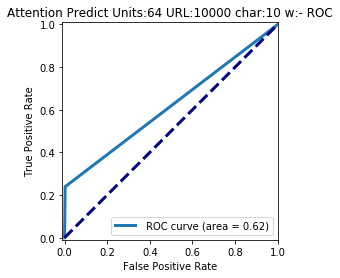

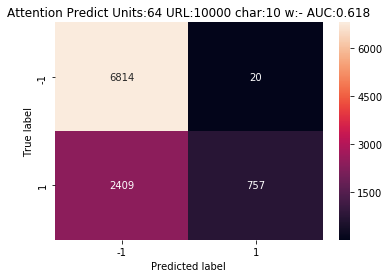

In [21]:
round_fun = lambda x: ['1'] if x == '+' else ['0']
y_predict = np.apply_along_axis(round_fun, 1, predicted_mc)
y_true = np.apply_along_axis(round_fun, 1, test_Y[:10000])
make_ndir('attn')
plot_cm(y_predict, '%s %s Units:%d URL:%d char:%d w:%s' % ('Attention', 'Predict', n_s, len(y_true), Tx ,'-' ), y_true, ['-1', '1'])

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 96)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 64)       33024       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 10, 64)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenat